## Mouse 🐁 : M044

Session: M044_2024_12_04_09_30

## Tuning parameters for optimal RNN training

In [1]:
# imports
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import mat73
from IPython.display import display, Markdown

import pyaldata as pyal
import pylab
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
import importlib

from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd.RNN_functions import *

np.random.seed(44)

#### Importing file

In [2]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
mat_file = "M044_2024_12_04_09_30_pyaldata.mat"
fname = os.path.join(data_dir, mat_file)

df = pyal.mat2dataframe(fname, shift_idx_fields=True)
mouse = mat_file.split('_')[0]

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


#### Preprocessing

In [3]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

# if you dont want to run it on all trials
df_ = pyal.select_trials(df_, f"values_Sol_direction < 5") 

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


#### Seperate regions

In [4]:
# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["Dls_rates", "M1_rates"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

#### Variables

In [5]:
# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_seconds = perturbation_time * df_.bin_size[0]

# solenoid angles
sol_angles: list = df_.values_Sol_direction.unique()
sol_angles.sort()

# number of trials
num_trials = len(df_)
print(f"Number of trials: {num_trials}")

Number of trials: 226


#### Concat trials in time

In [6]:
concat_trials = pyal.concat_trials(df_, signal = "all_rates")

## RNN training loop

In [7]:
dtFactors = [1, 2, 3, 4, 5]
tauRNNs = [0.2, 0.3]
ampInWNs = [0.001, 0.01]

rnn_models = []

for dtFactor in dtFactors:
    reset_points, trial_len = get_reset_points(df_, concat_trials, brain_areas, dtFactor)
    activity = np.transpose(concat_trials)
    regions = get_regions(df_, brain_areas)

    for tauRNN in tauRNNs:
        for ampInWN in ampInWNs:
                rnn_model = RNN(activity, reset_points, regions, df_, mouse, graph=False,
                dtFactor = dtFactor, ampInWN= ampInWN, tauRNN = tauRNN, nRunTrain=20) # 20 should be suffucient to get a good estimate of the parameters
                params = [dtFactor, tauRNN, ampInWN, trial_len, reset_points]
                result = [params, rnn_model]
                
                # Print results
                print(f"Model with parameters:")
                print(f"dtFactor: {dtFactor}, tauRNN: {tauRNN}, ampInWN: {ampInWN}")
                print(f"Model final accuracy: pVar={rnn_model['pVars'][-1]}, chi2={rnn_model['chi2s'][-1]}\n")

                # Save the model
                params = [dtFactor, tauRNN, ampInWN, trial_len, reset_points]
                result = [params, rnn_model]
                rnn_models.append(result)


Model with parameters:
dtFactor: 1, tauRNN: 0.2, ampInWN: 0.001
Model final accuracy: pVar=0.49911282747790264, chi2=89.22792923846075

Model with parameters:
dtFactor: 1, tauRNN: 0.2, ampInWN: 0.01
Model final accuracy: pVar=0.4956373593437906, chi2=89.68313650225895

Model with parameters:
dtFactor: 1, tauRNN: 0.3, ampInWN: 0.001
Model final accuracy: pVar=0.5064151818475267, chi2=87.76256841198011

Model with parameters:
dtFactor: 1, tauRNN: 0.3, ampInWN: 0.01
Model final accuracy: pVar=0.5040616079850573, chi2=88.06129212336042

Model with parameters:
dtFactor: 2, tauRNN: 0.2, ampInWN: 0.001
Model final accuracy: pVar=0.5048281471661985, chi2=88.11898442694125

Model with parameters:
dtFactor: 2, tauRNN: 0.2, ampInWN: 0.01
Model final accuracy: pVar=0.5021326223805166, chi2=88.44853596401576

Model with parameters:
dtFactor: 2, tauRNN: 0.3, ampInWN: 0.001
Model final accuracy: pVar=0.5106697122849868, chi2=86.93887802673274

Model with parameters:
dtFactor: 2, tauRNN: 0.3, ampInWN:

#### Organizing RNN training results

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/notebooks/M044/../../tools/rnn_and_curbd/RNN_functions.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,6))


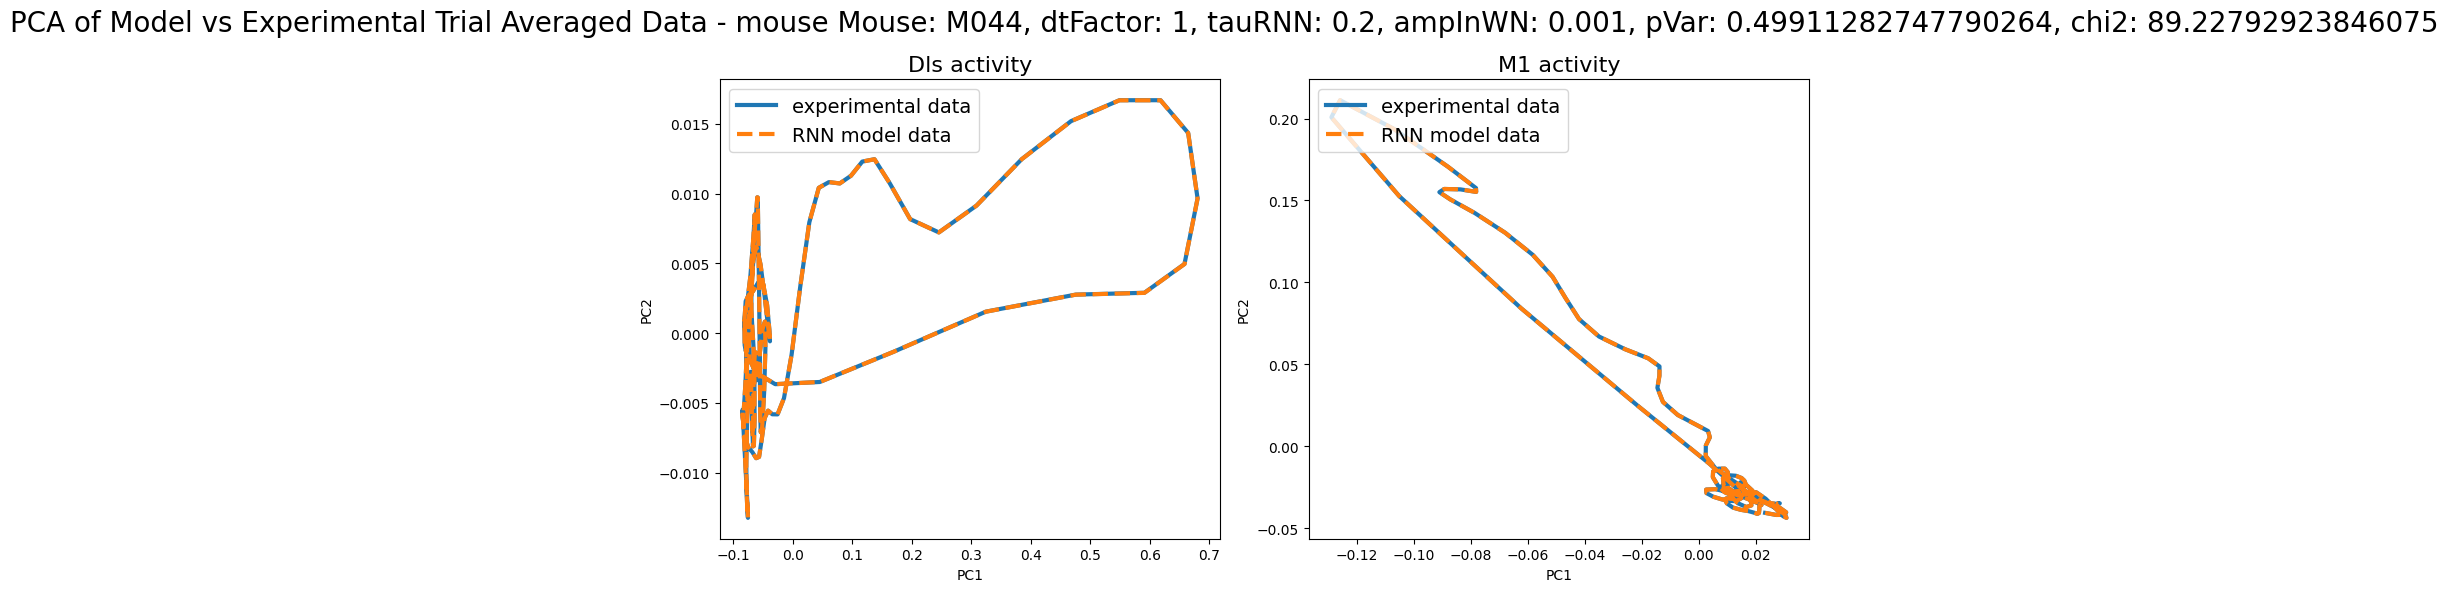

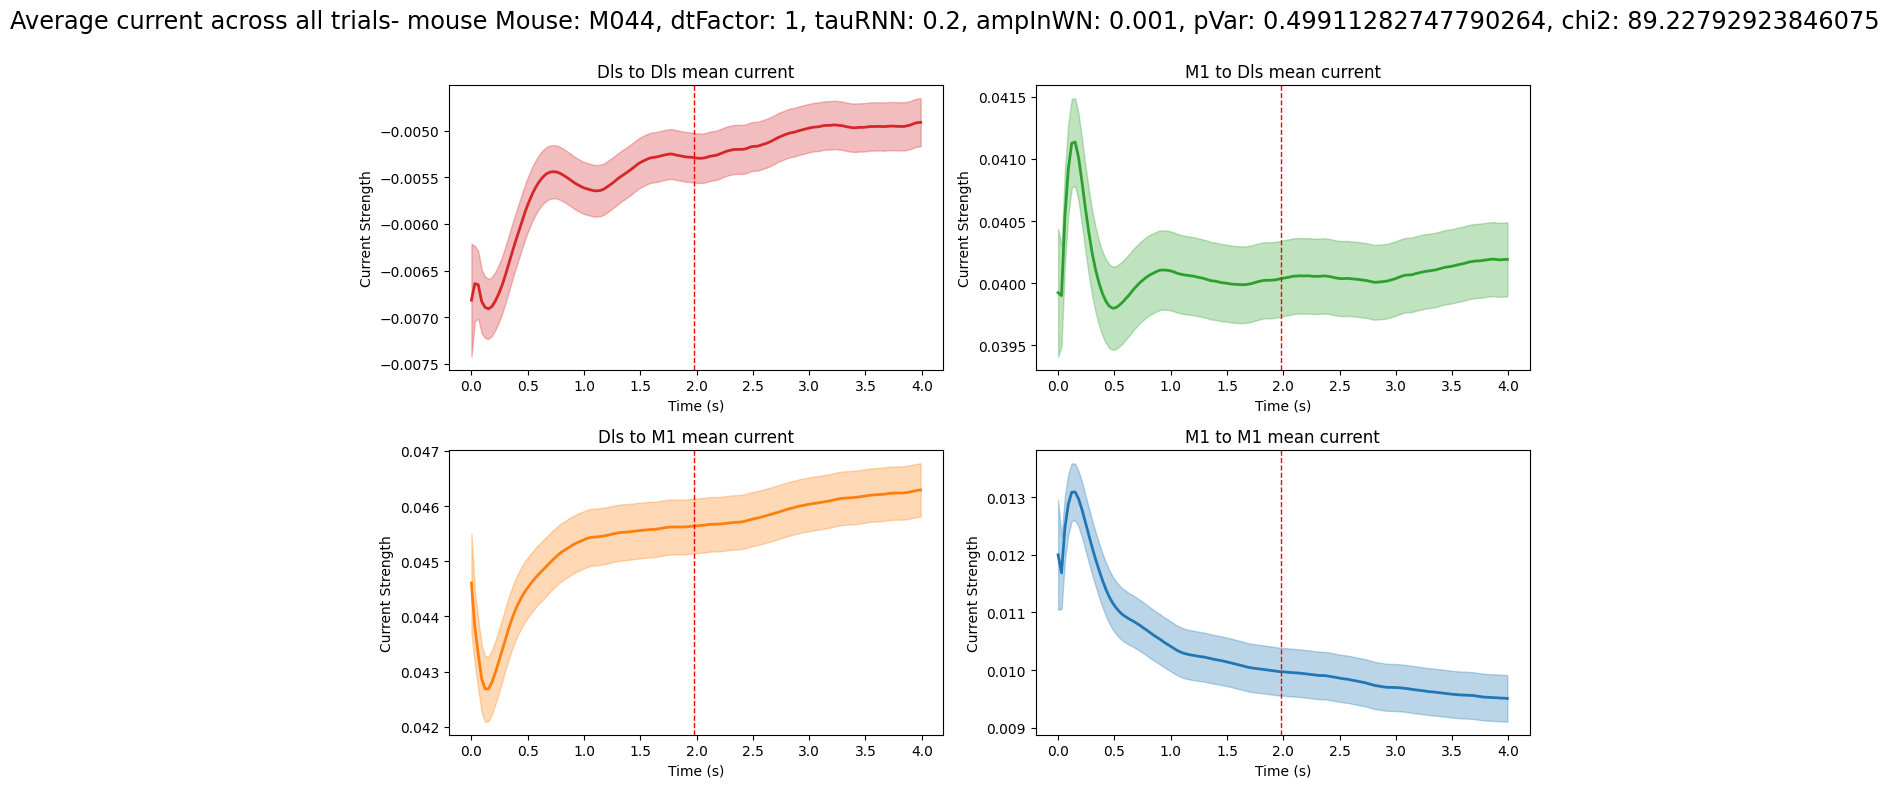

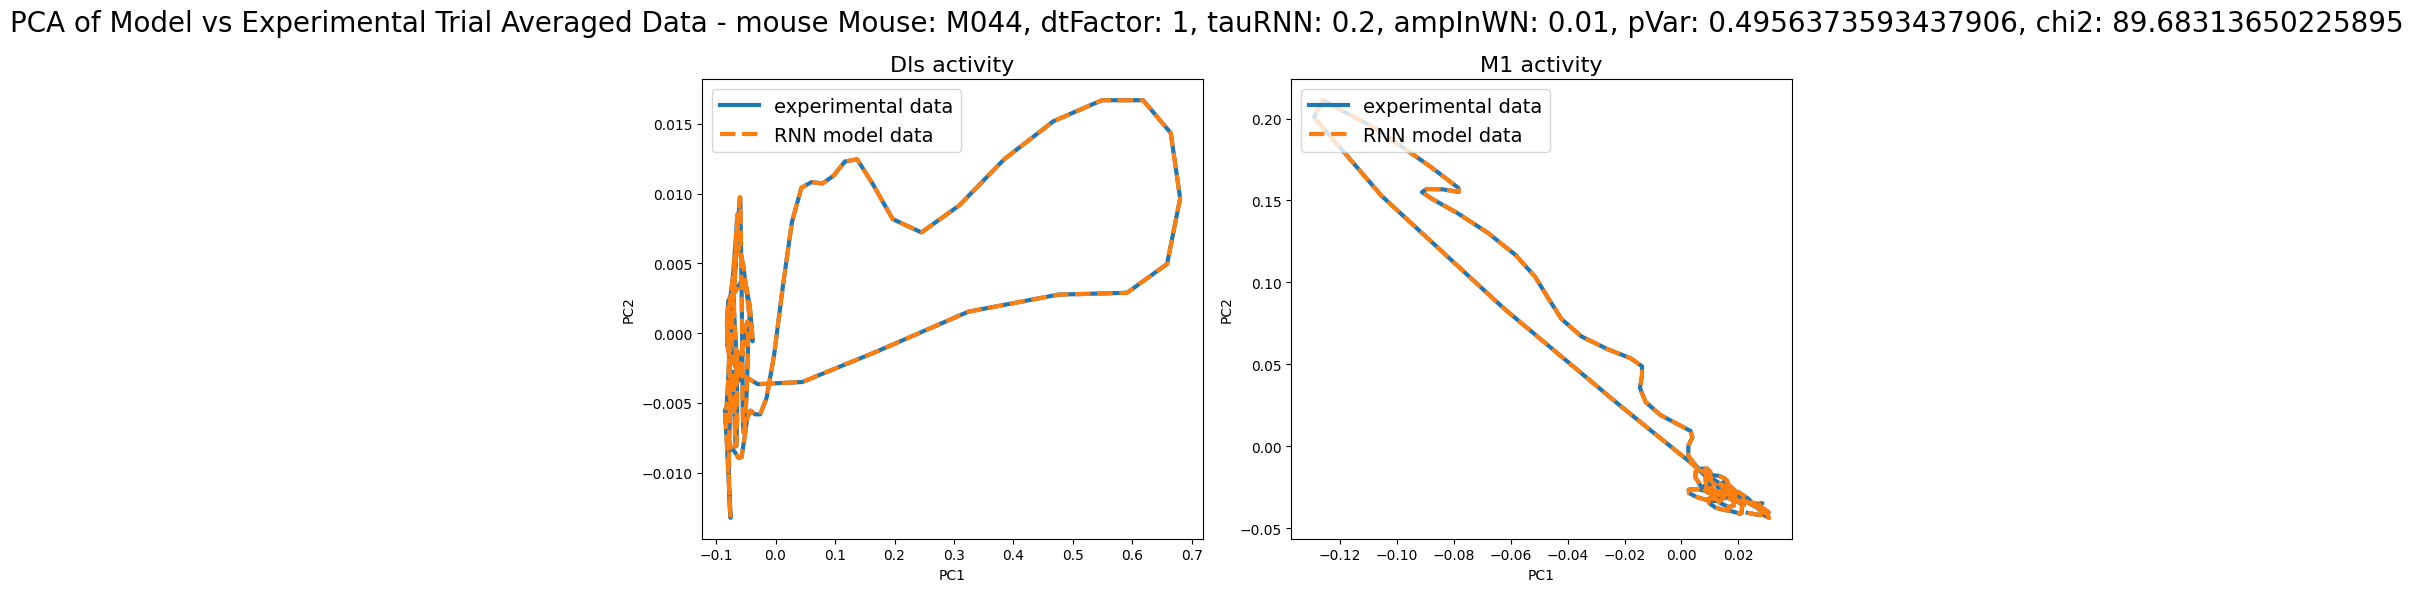

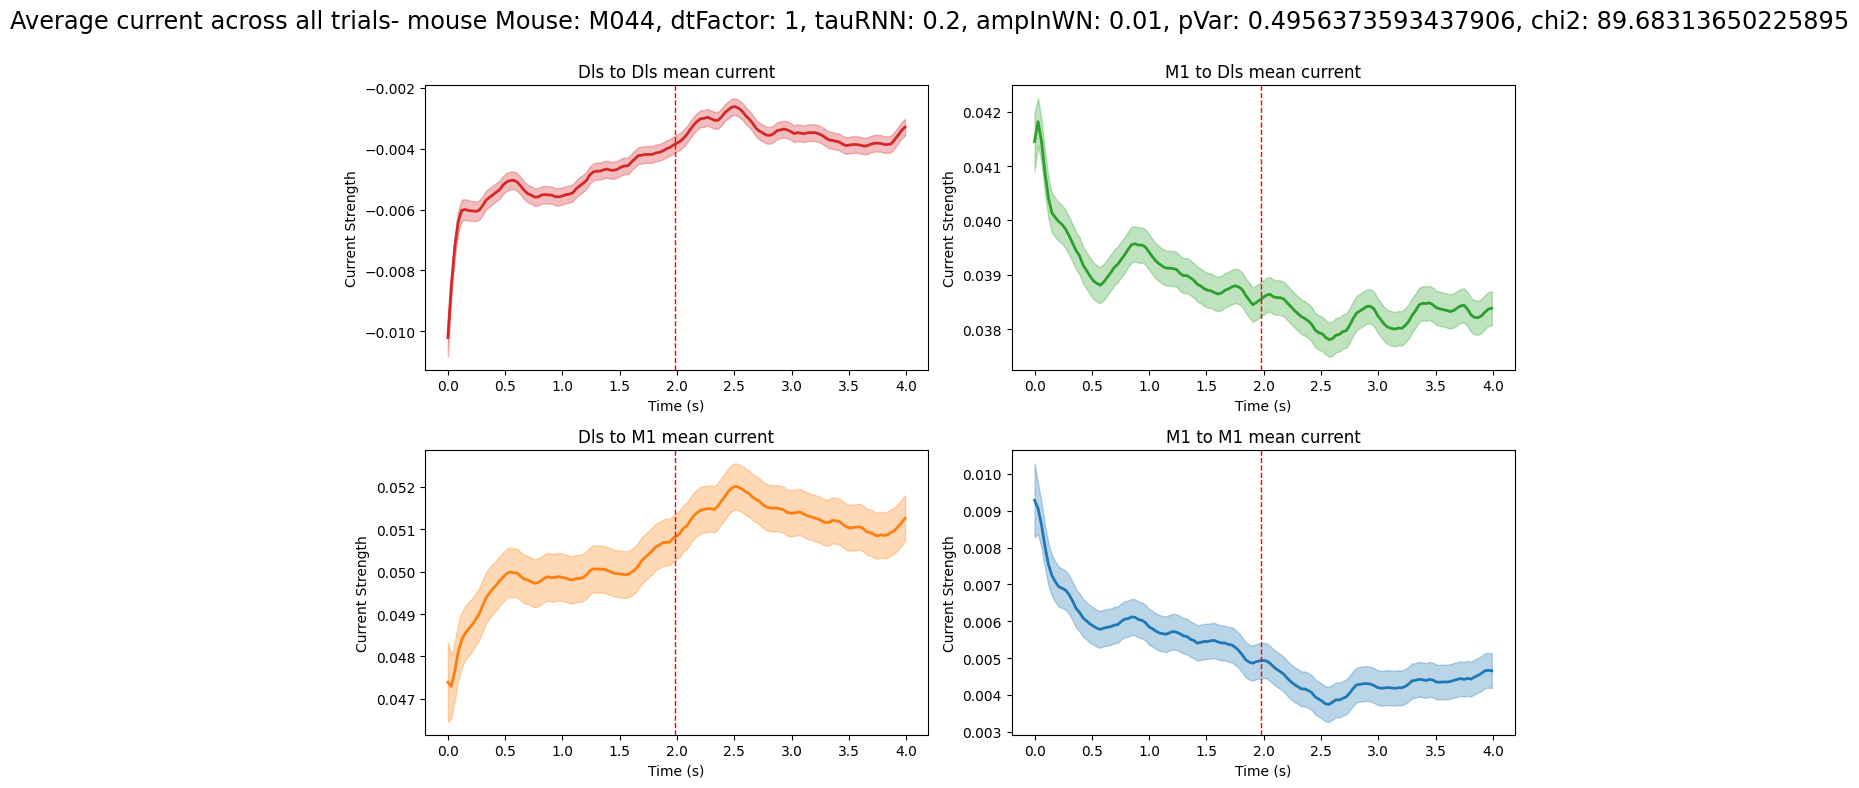

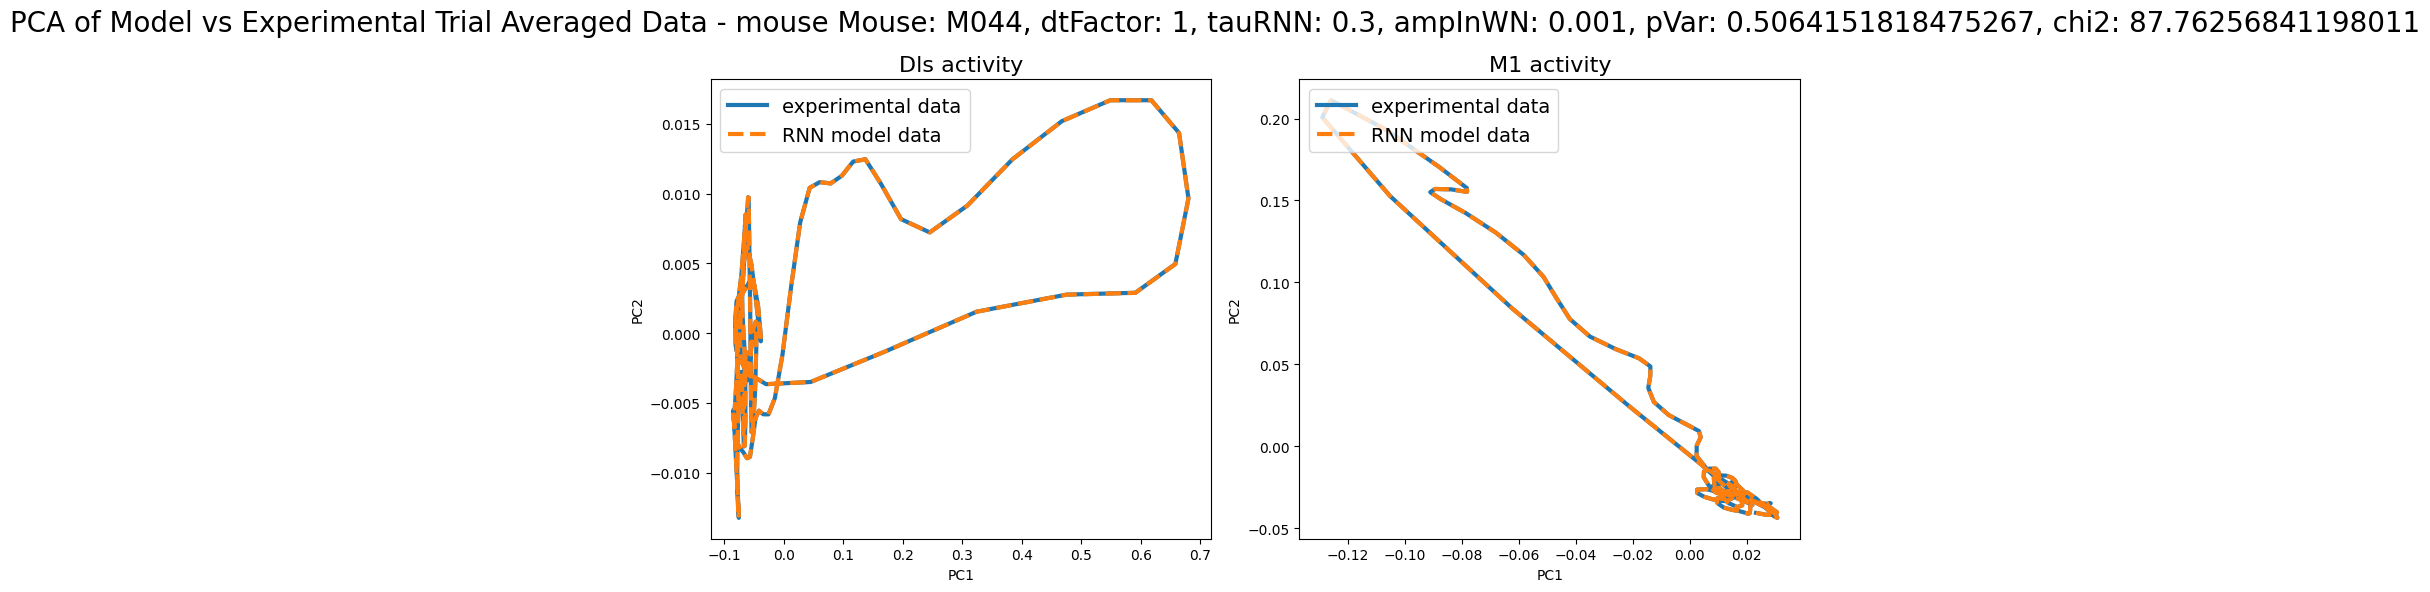

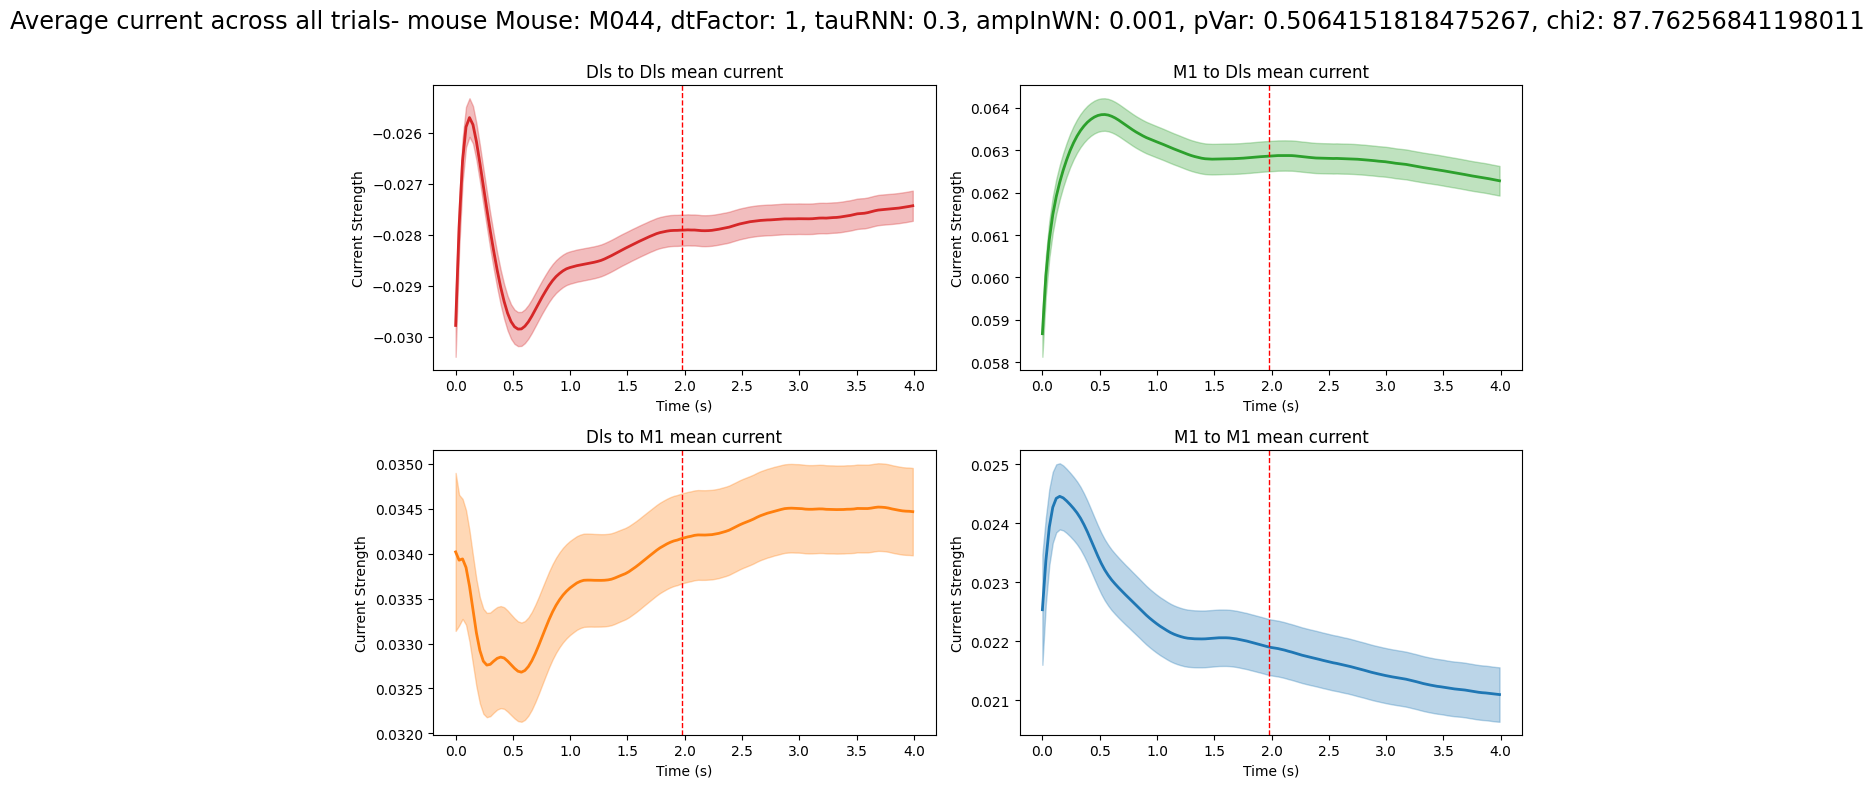

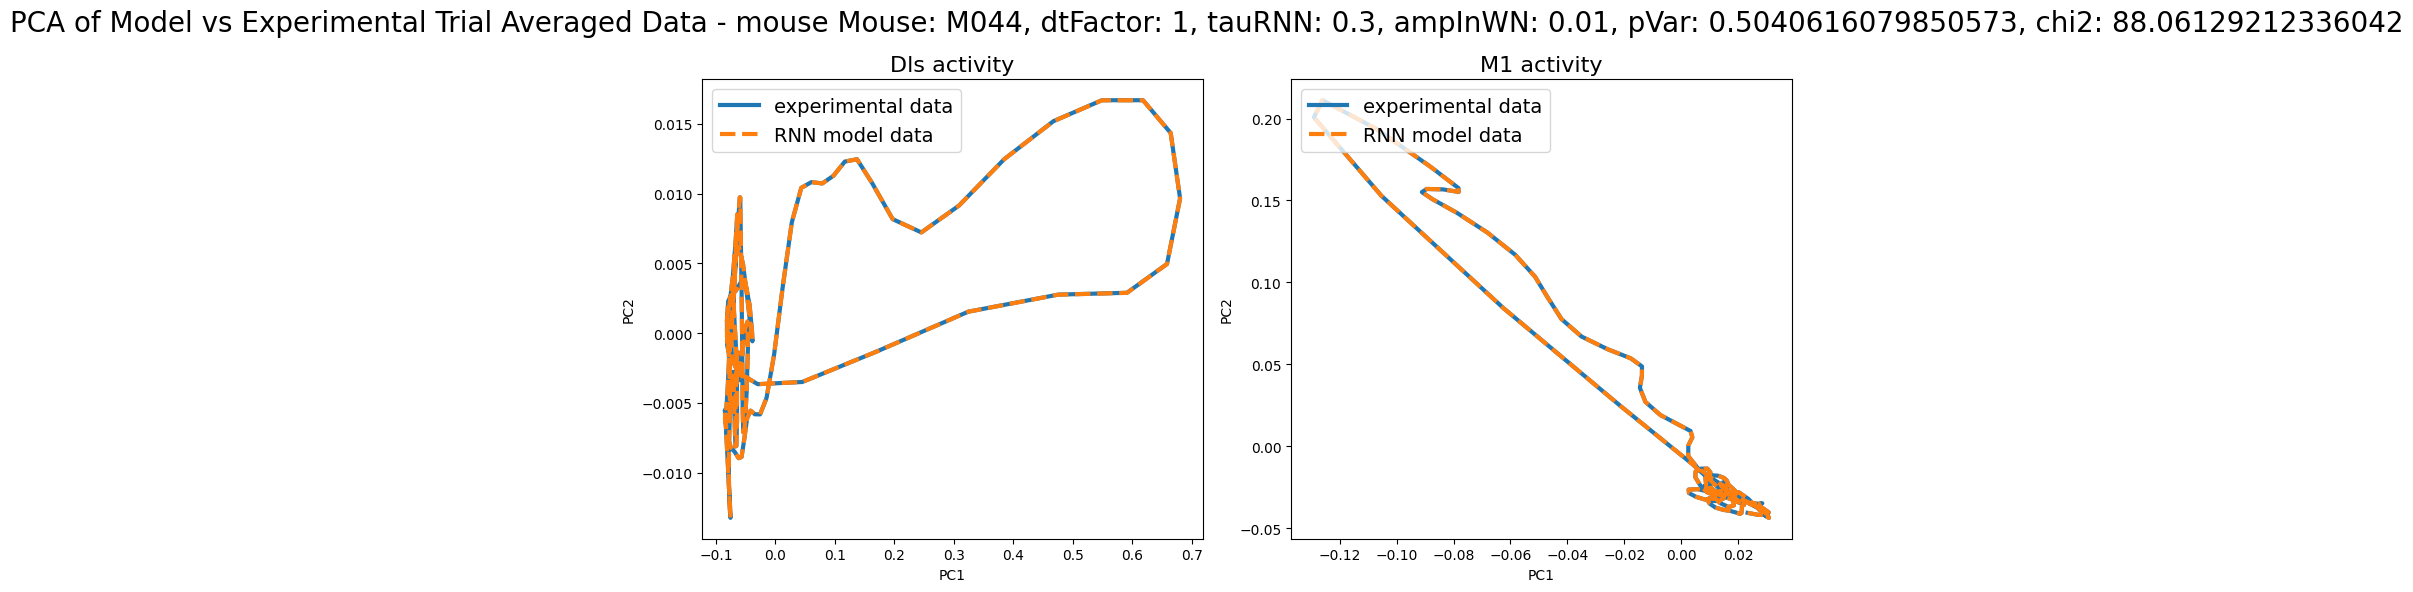

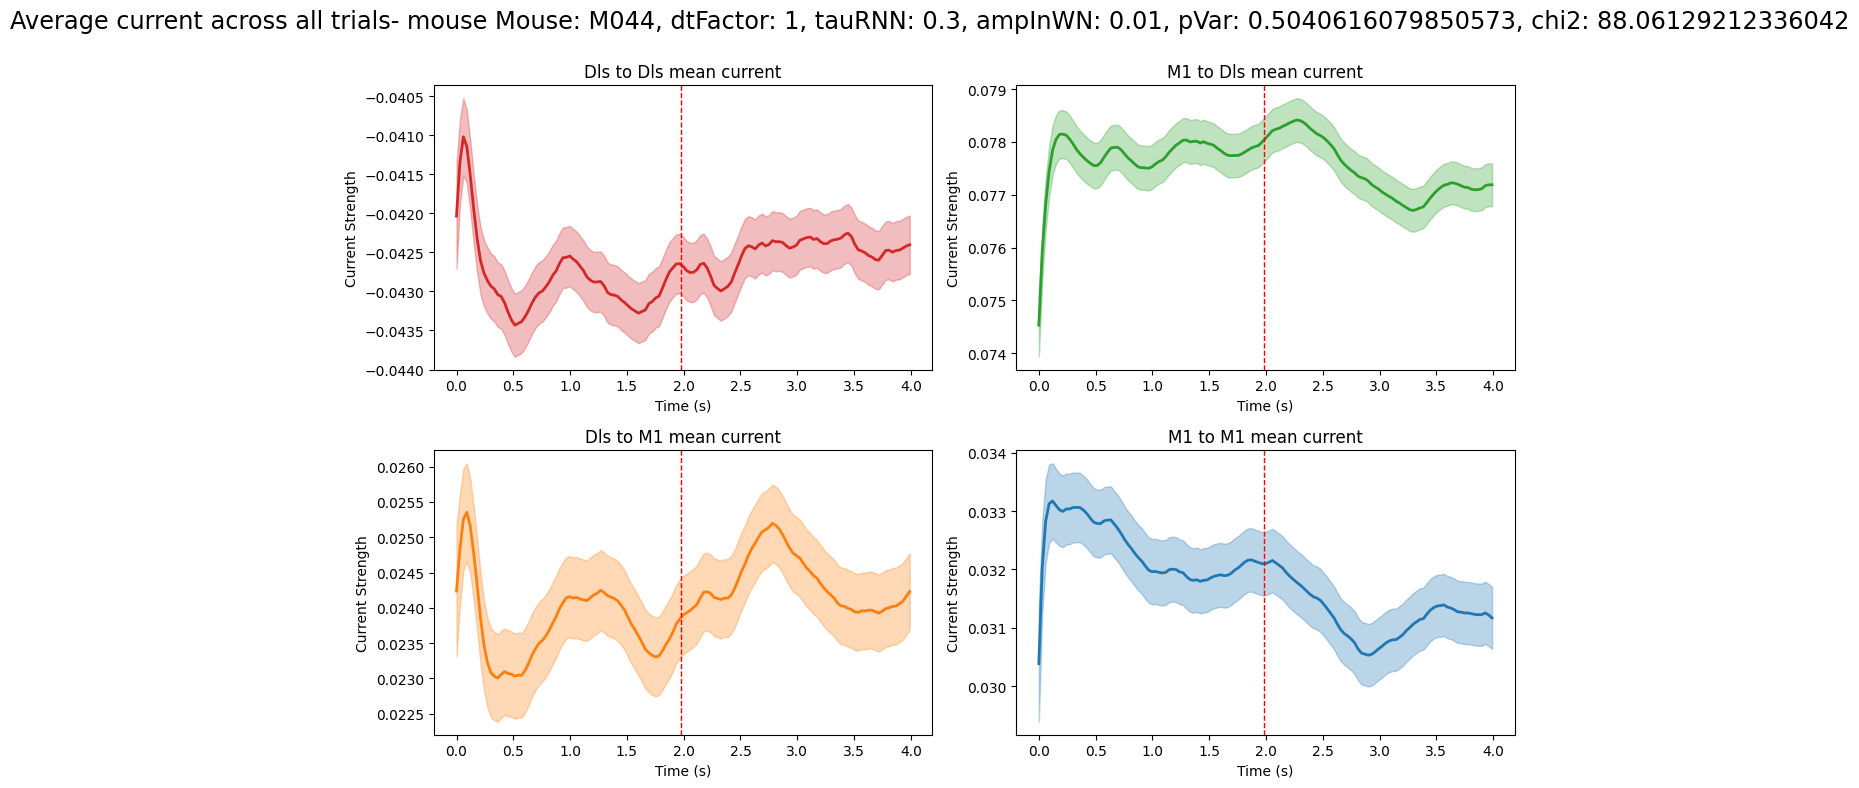

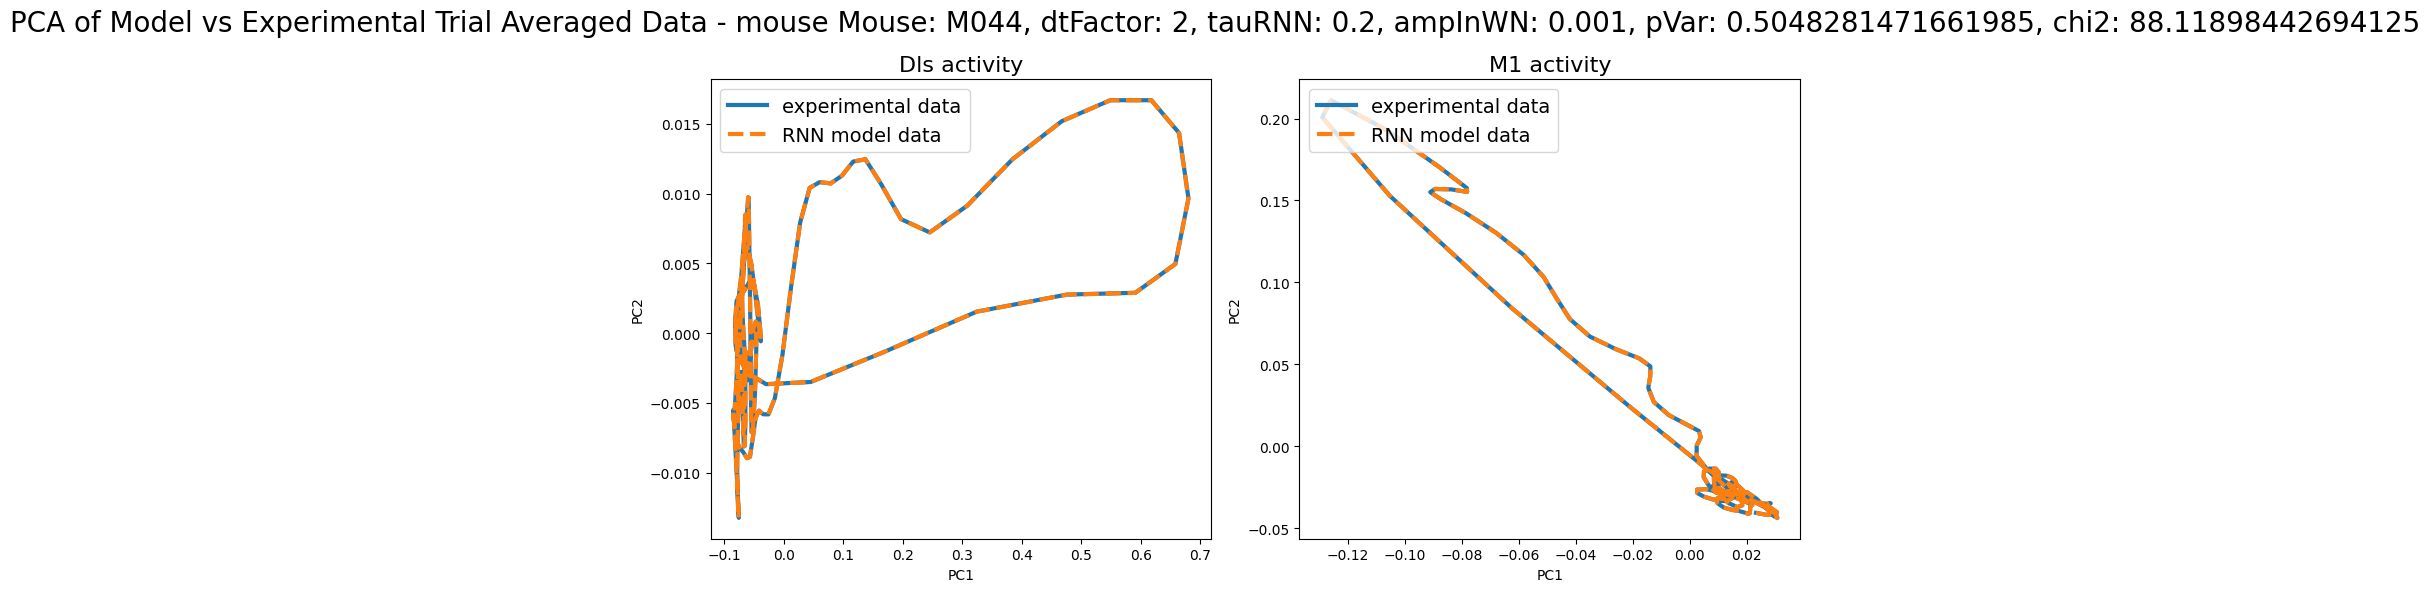

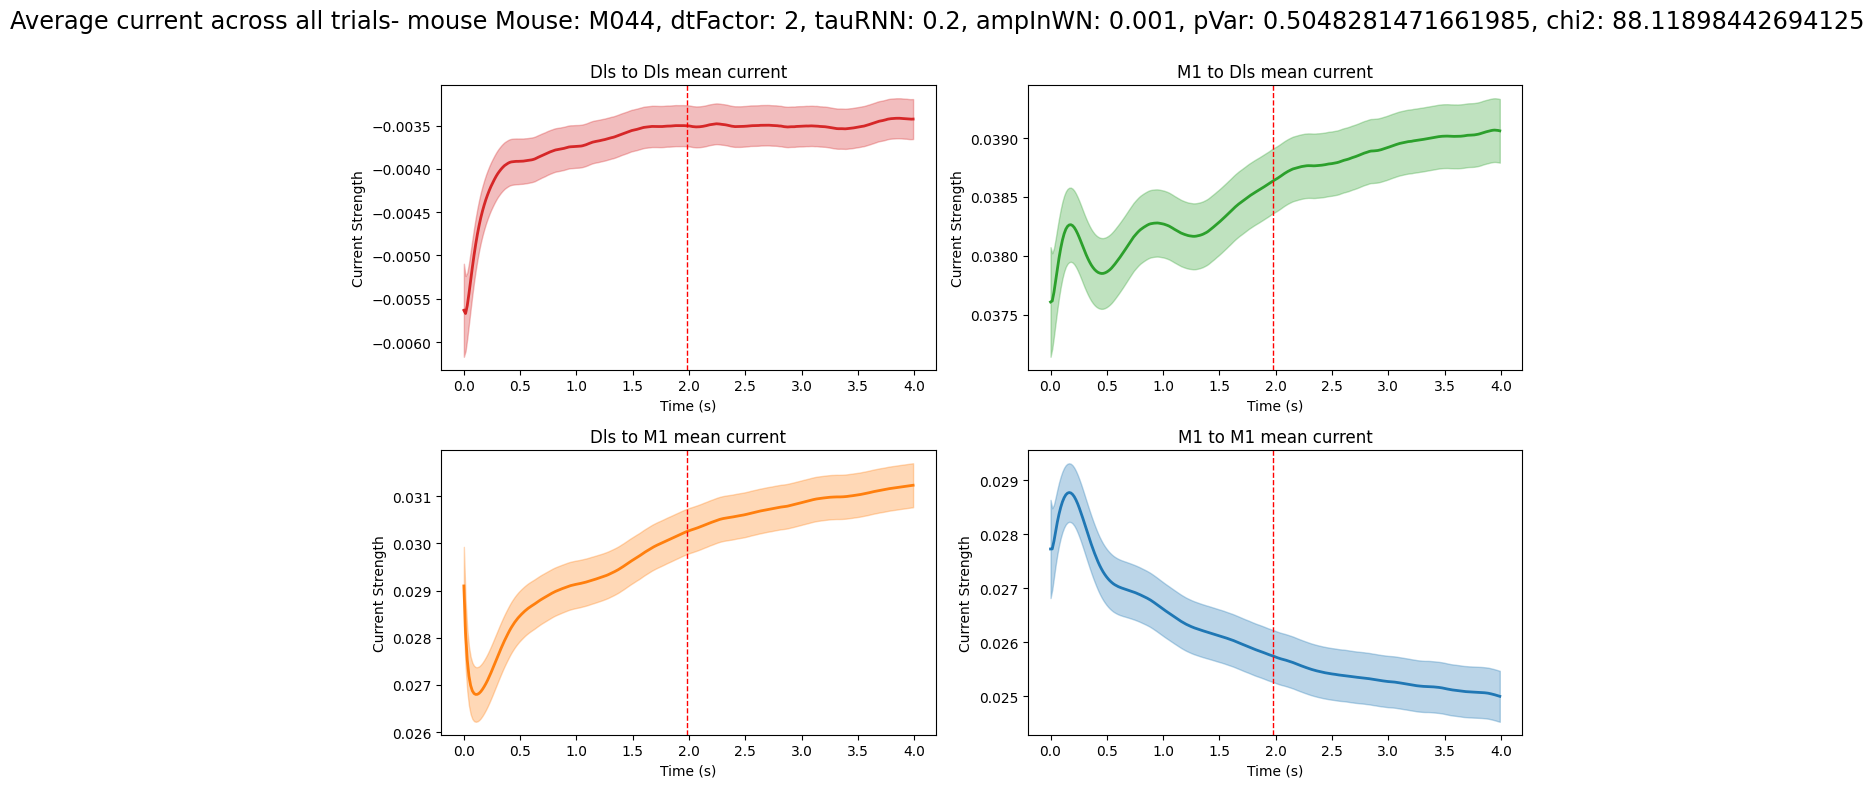

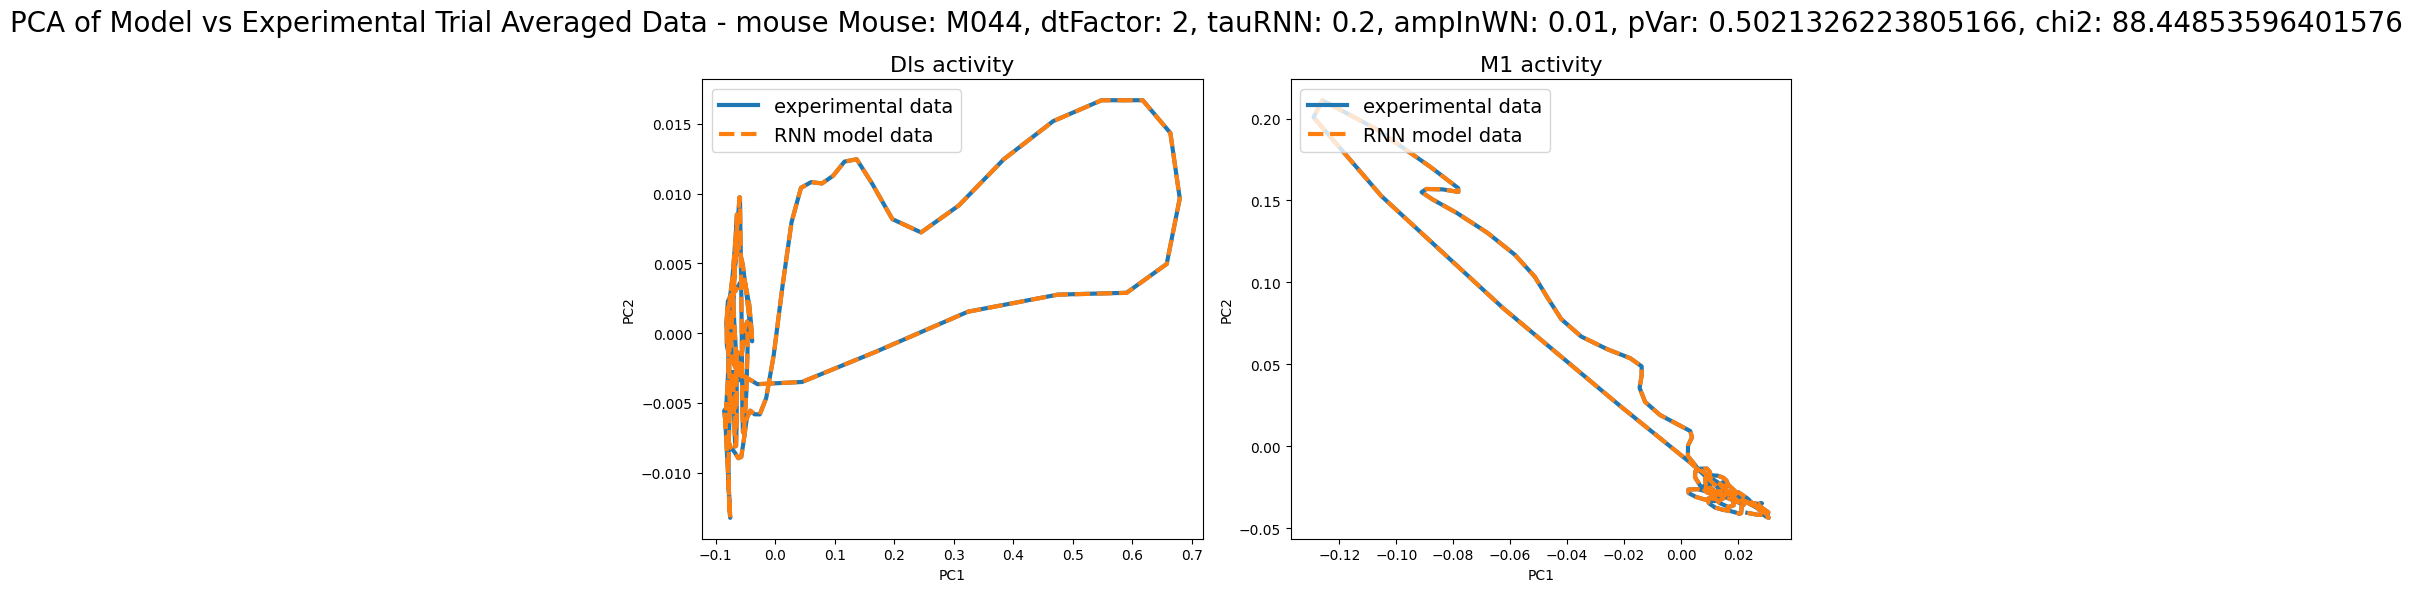

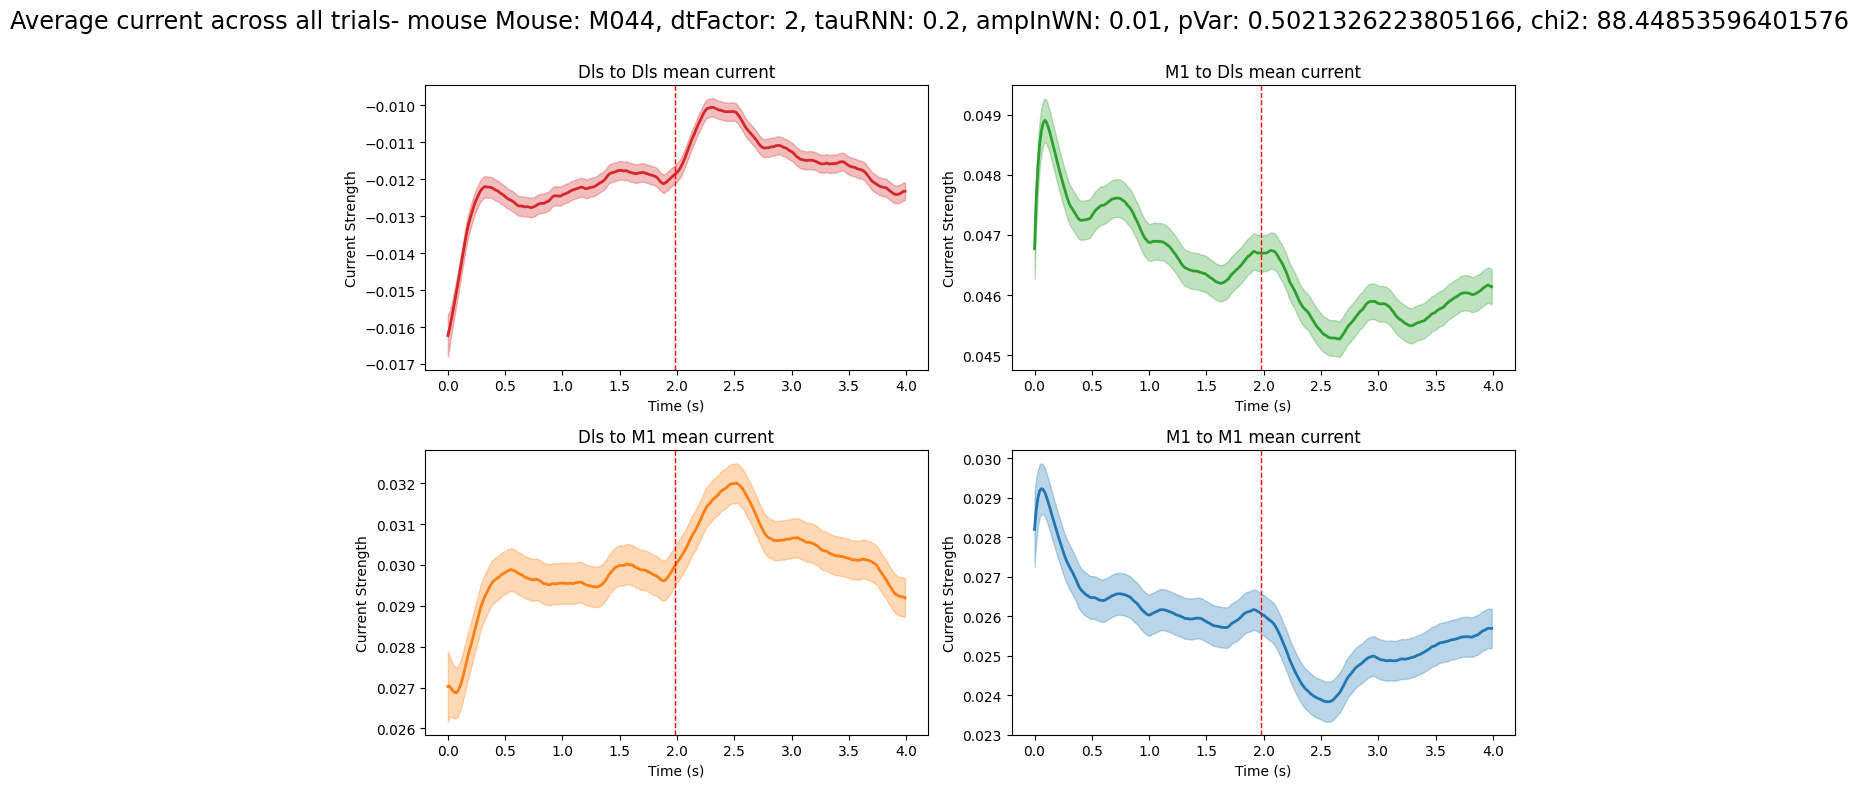

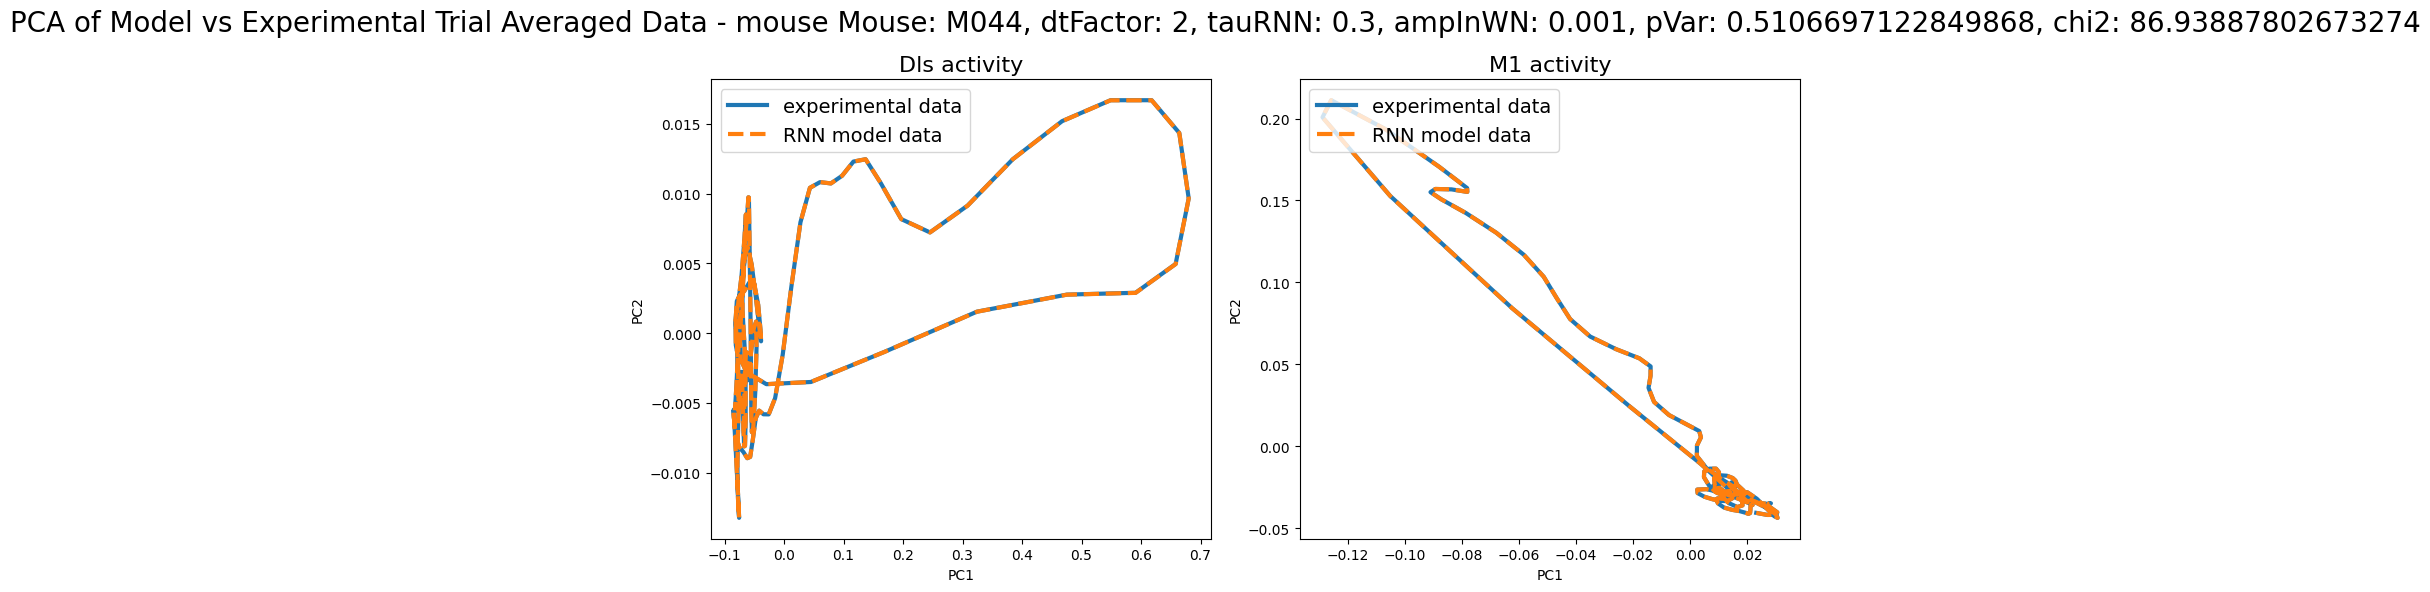

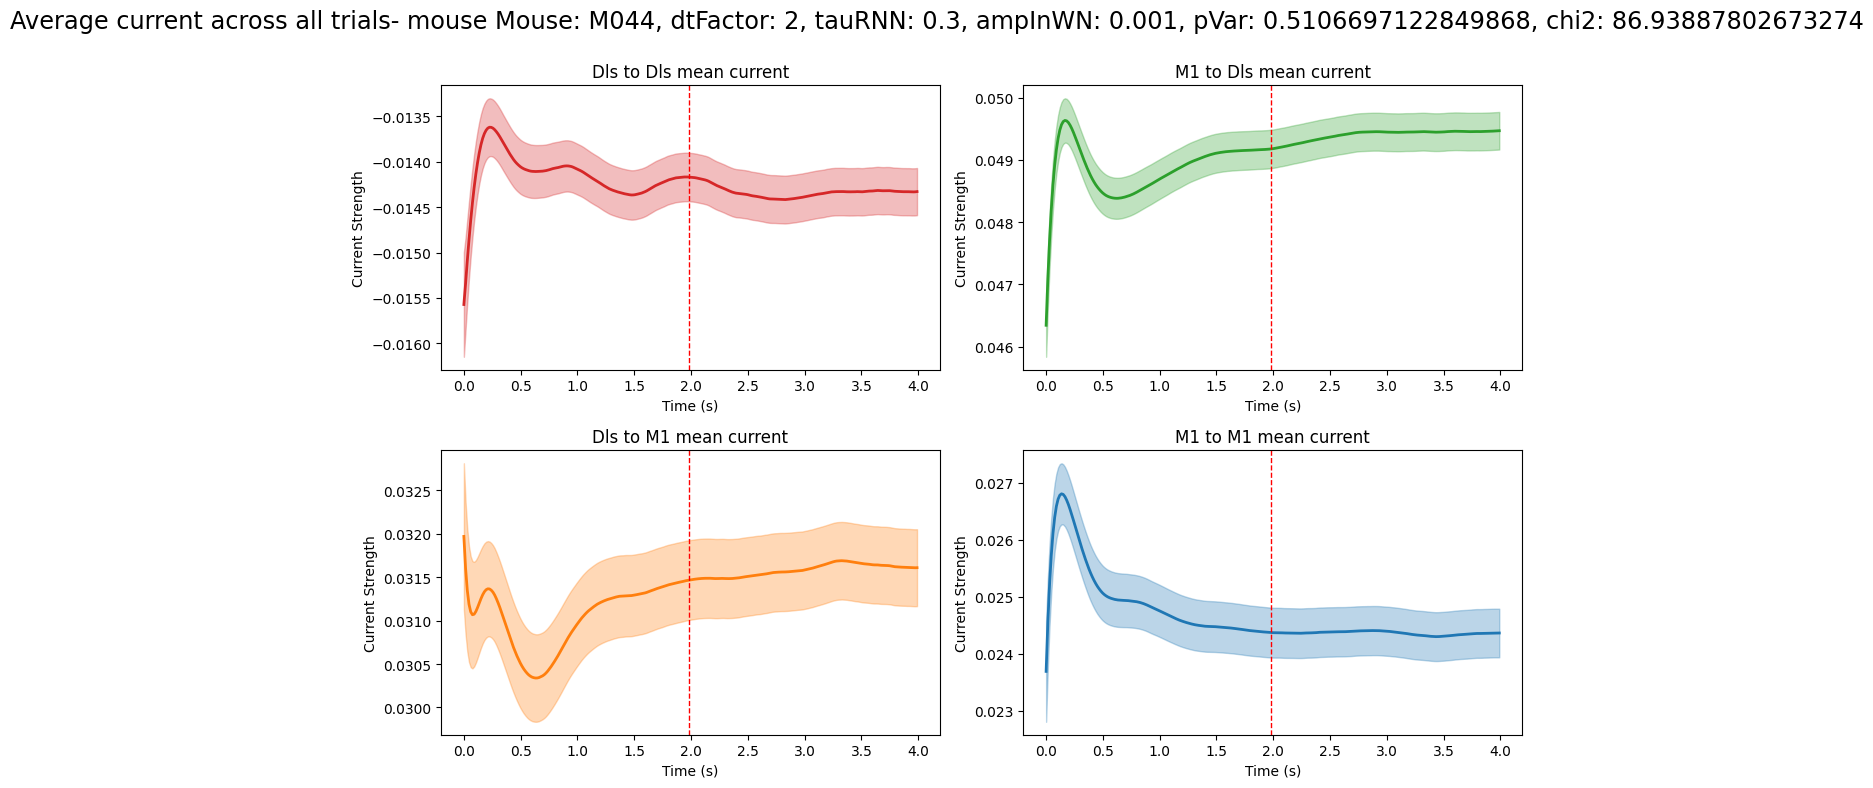

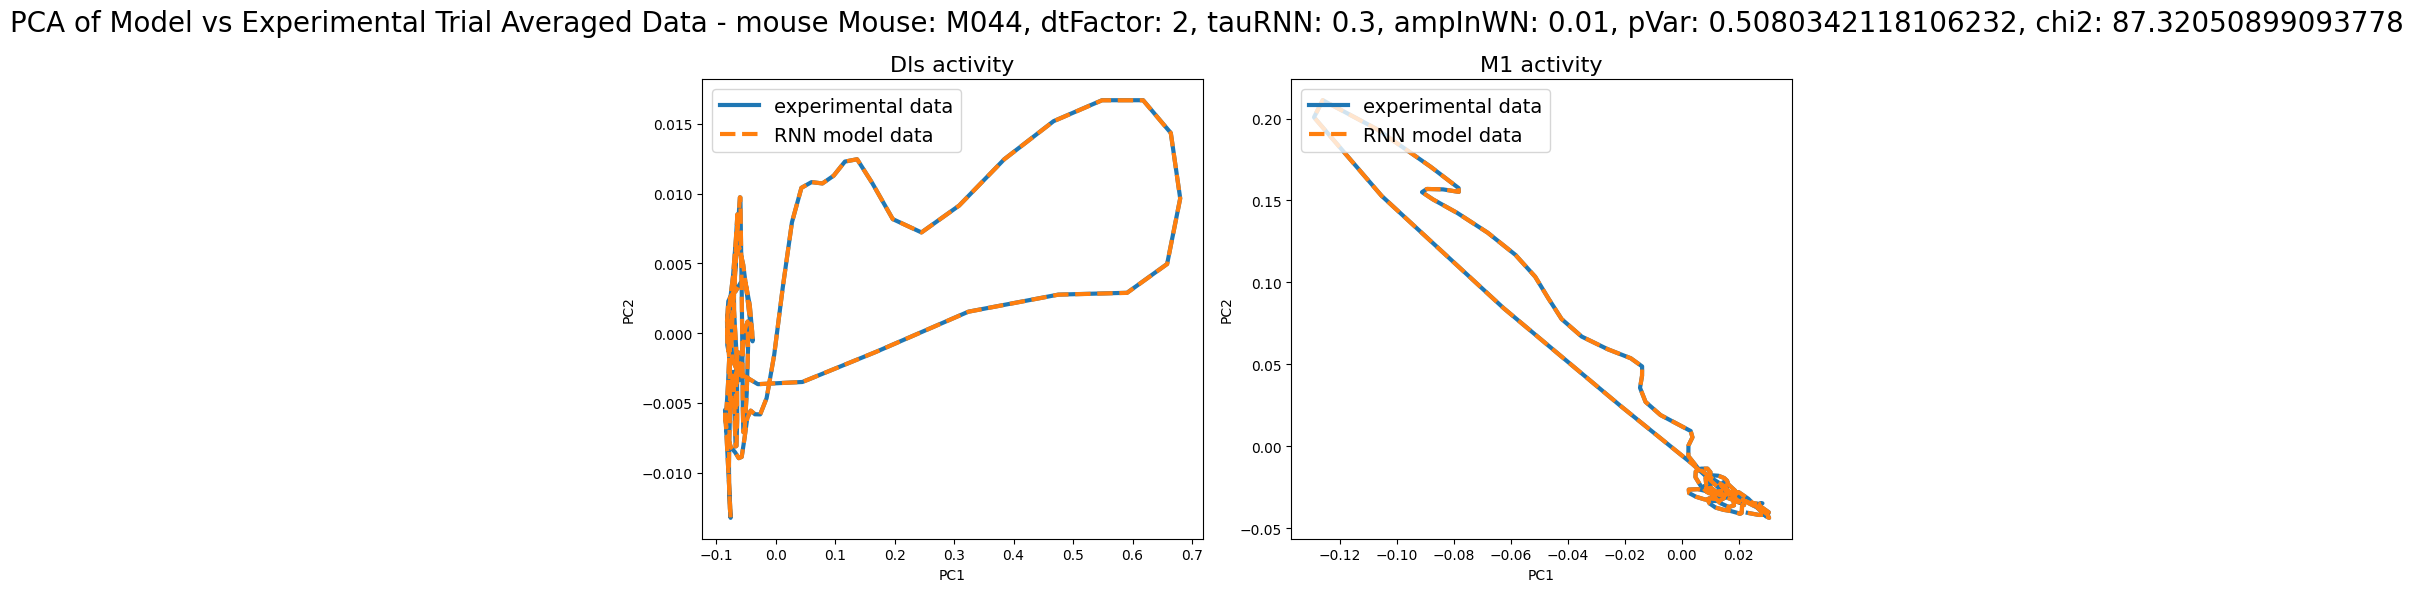

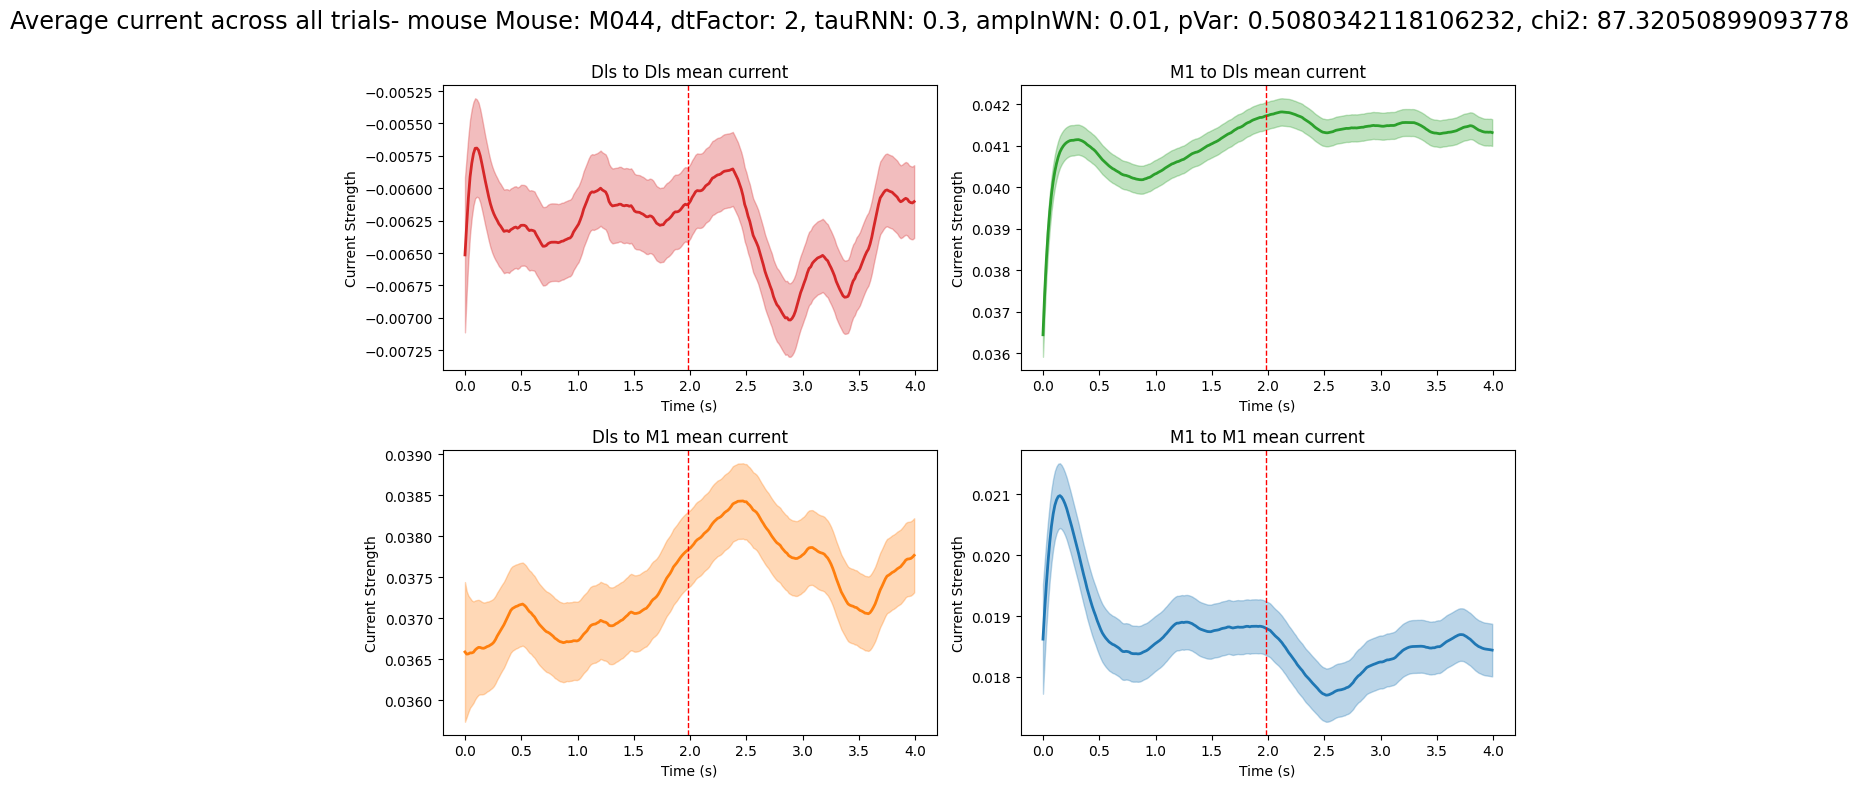

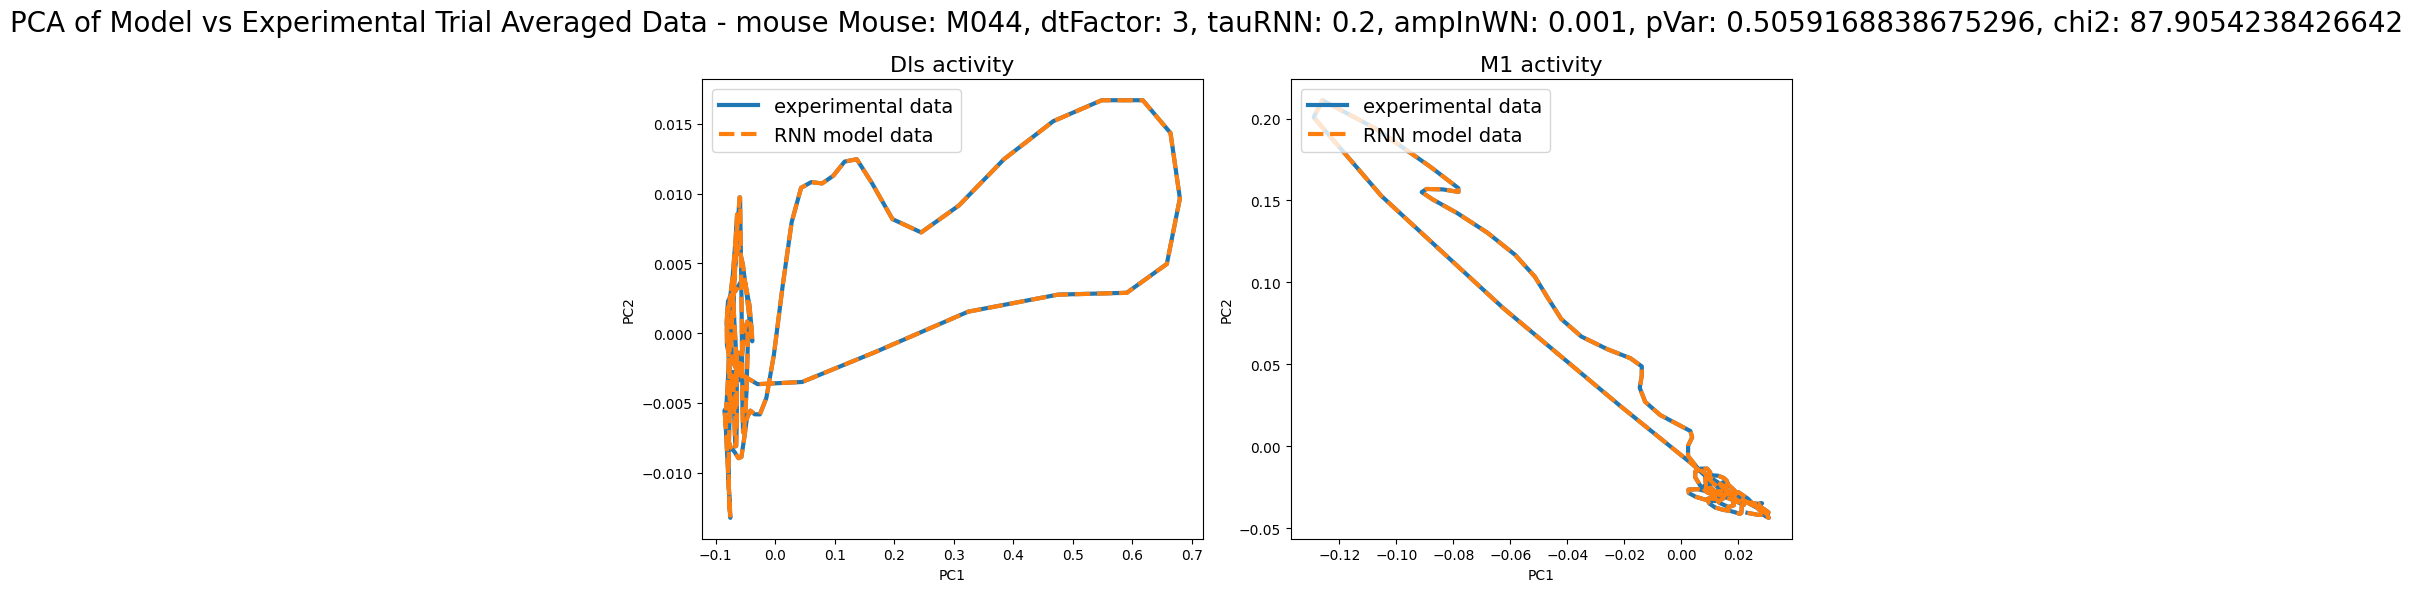

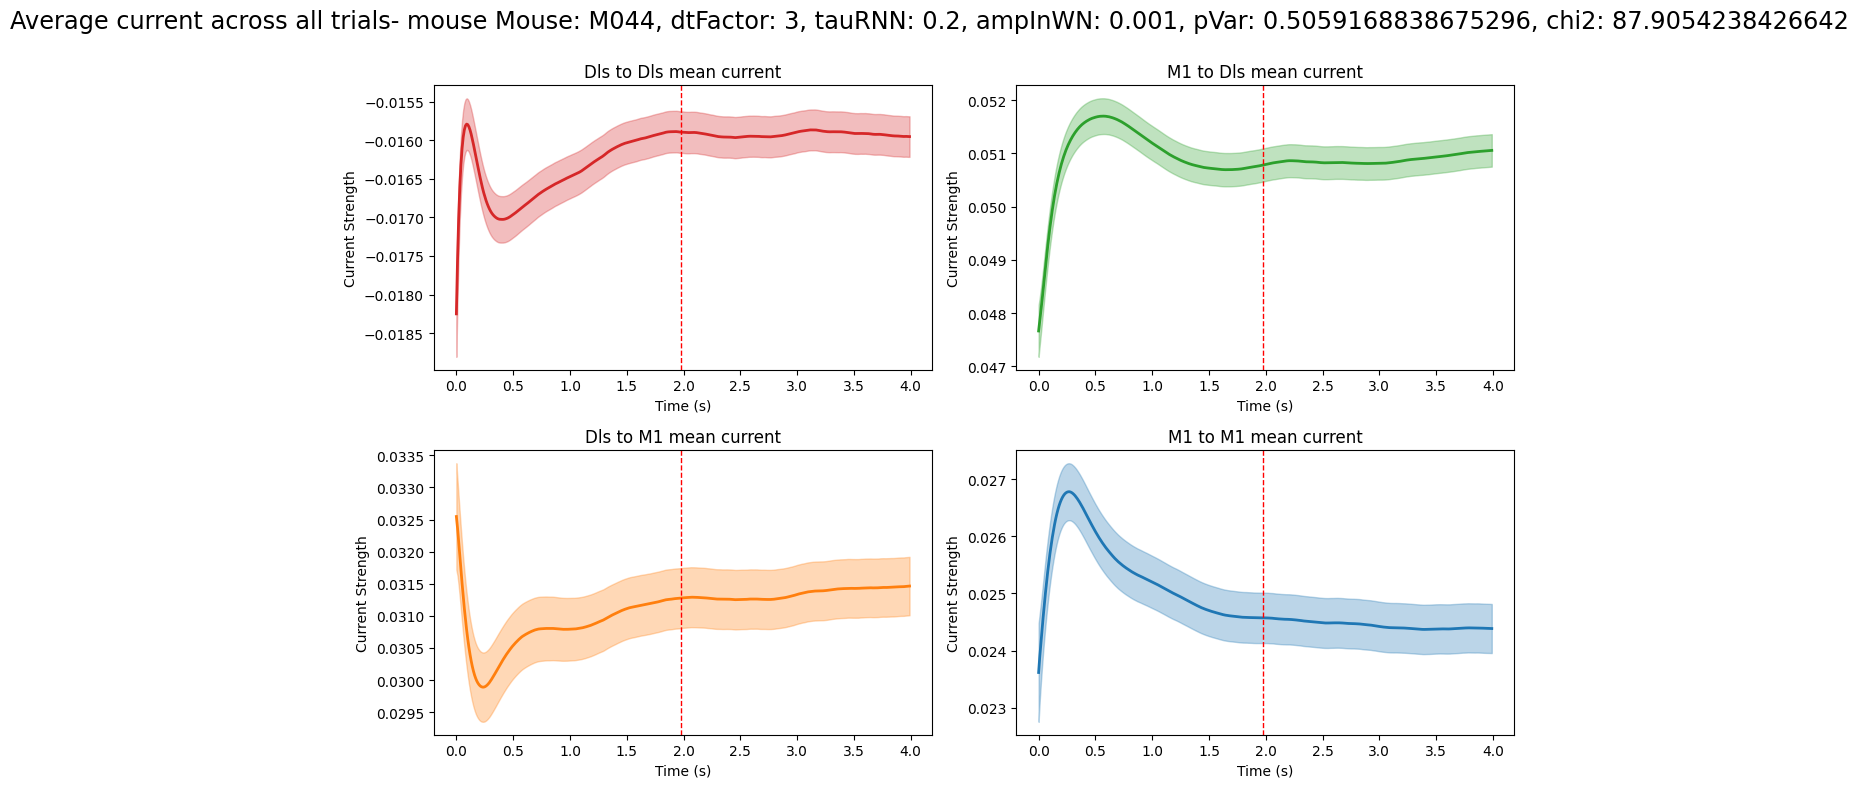

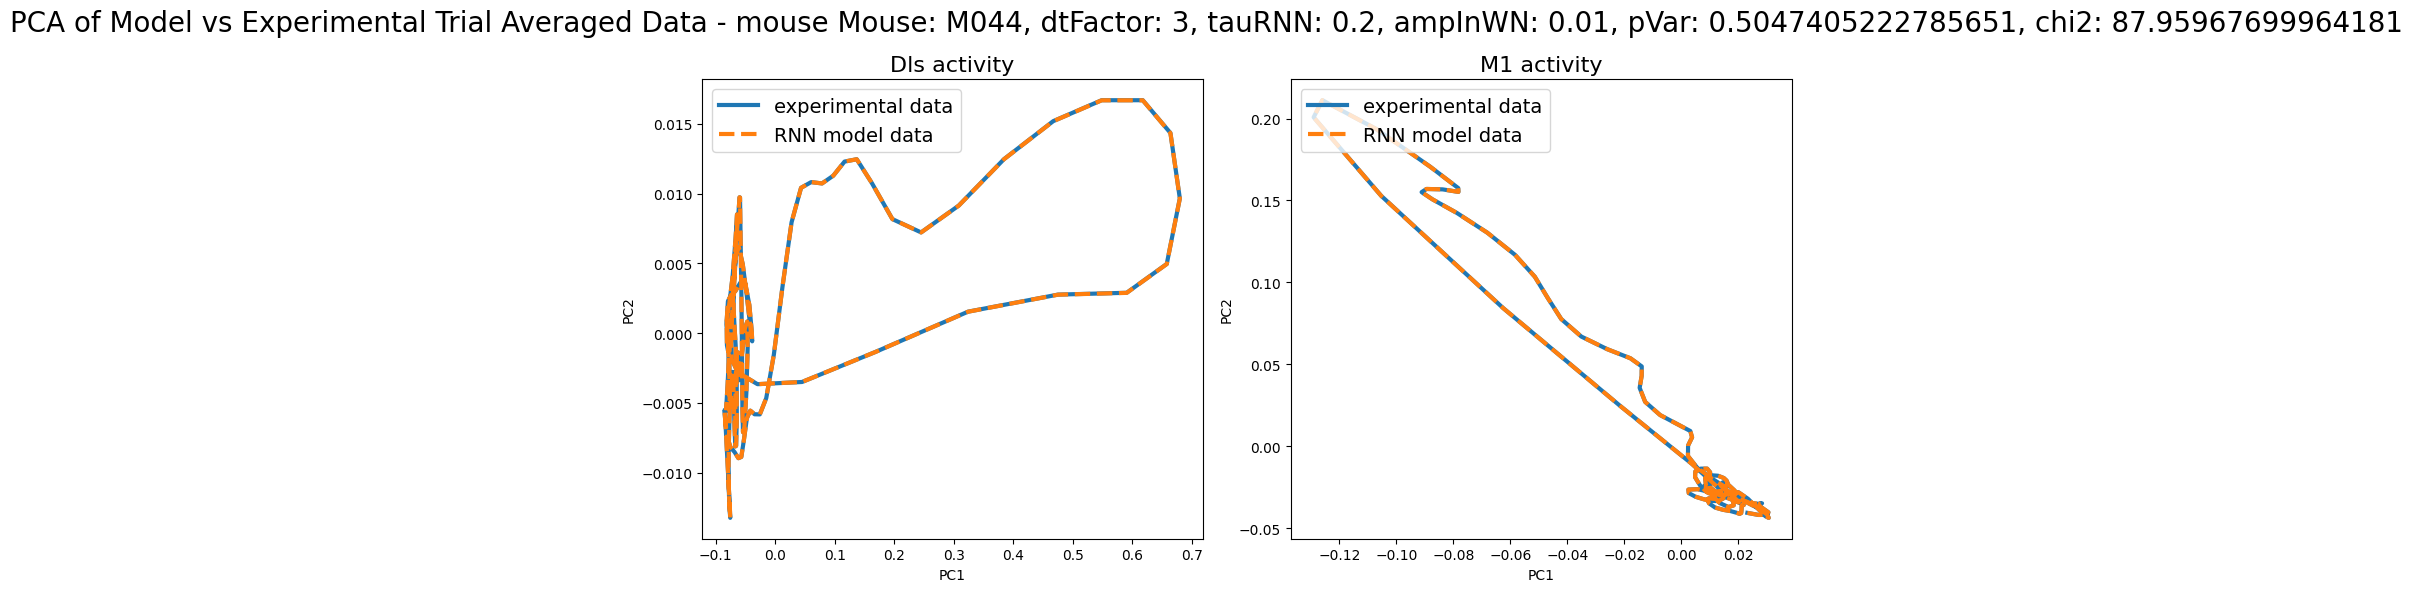

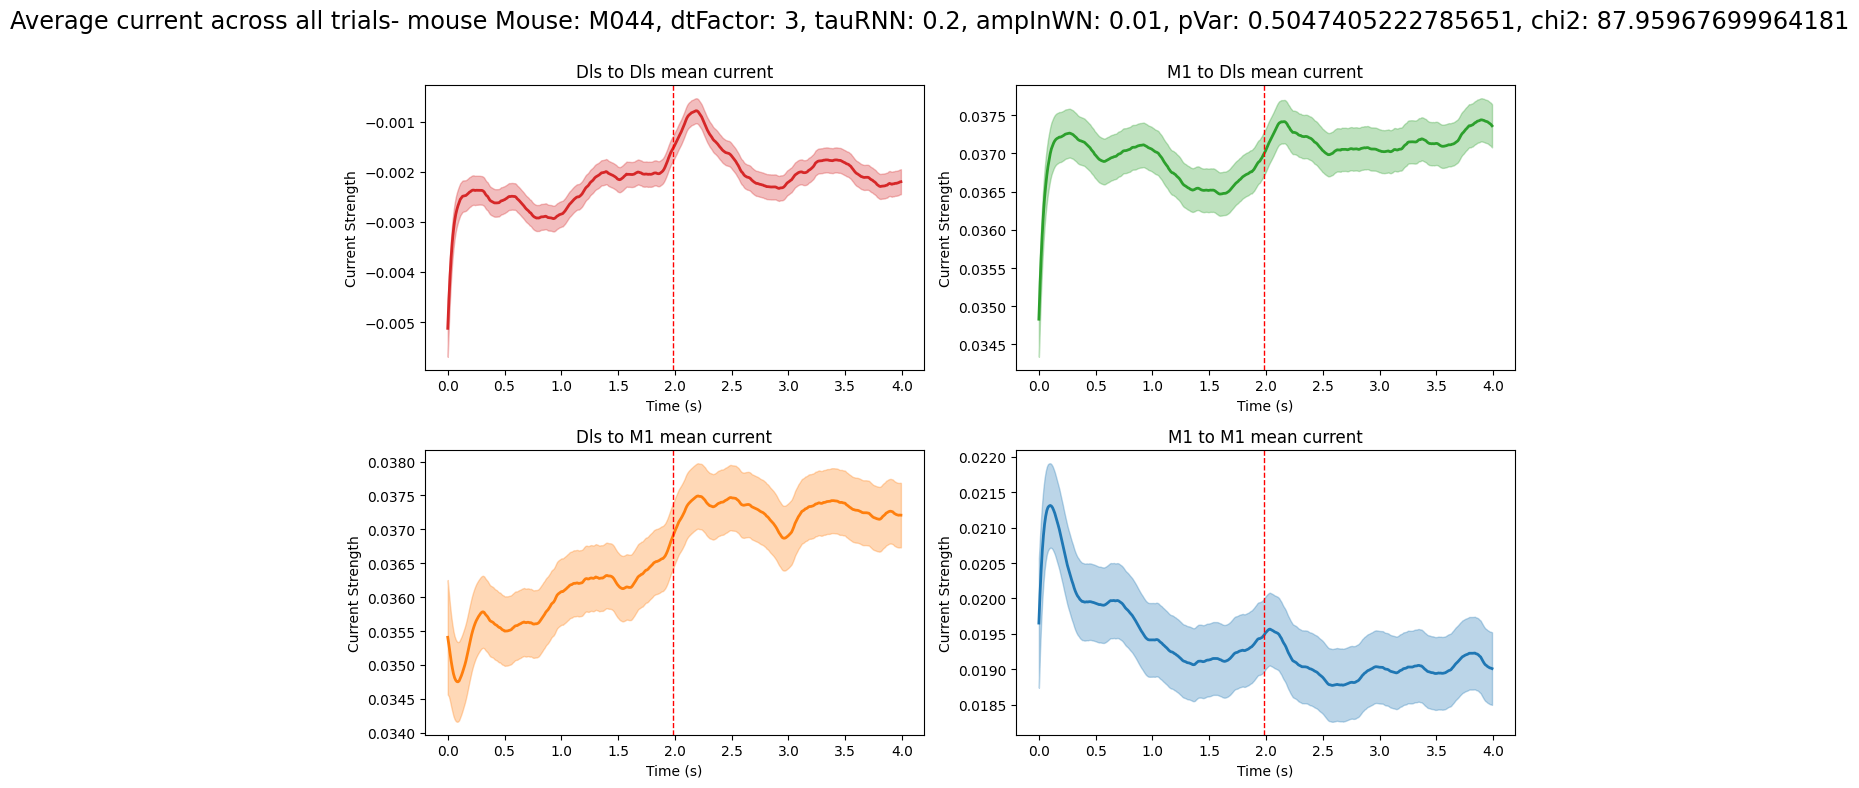

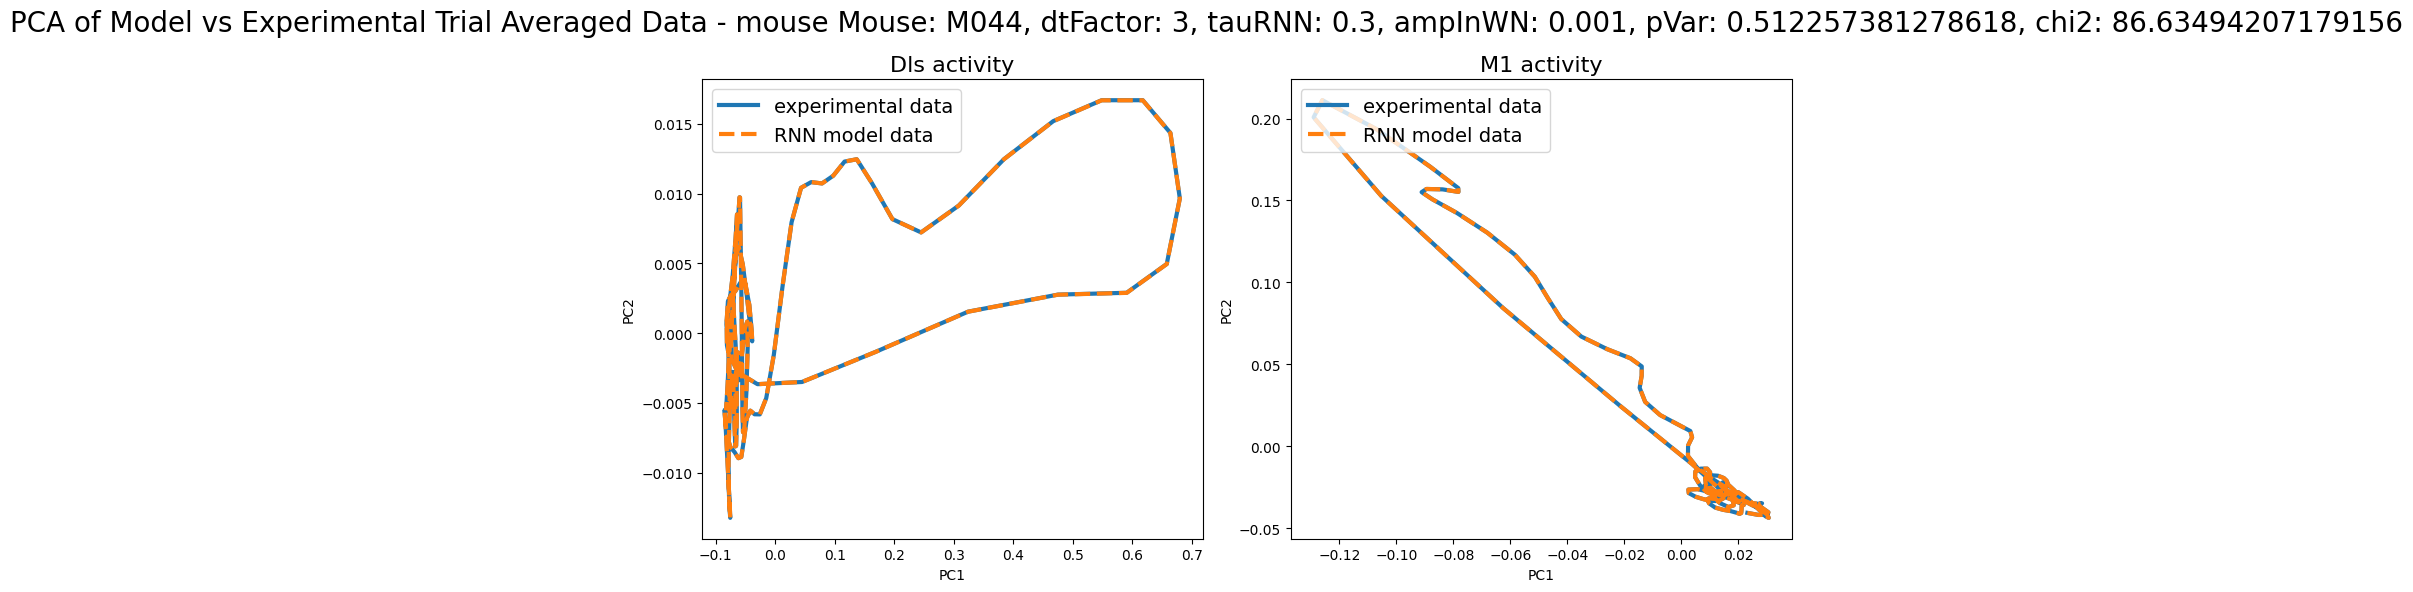

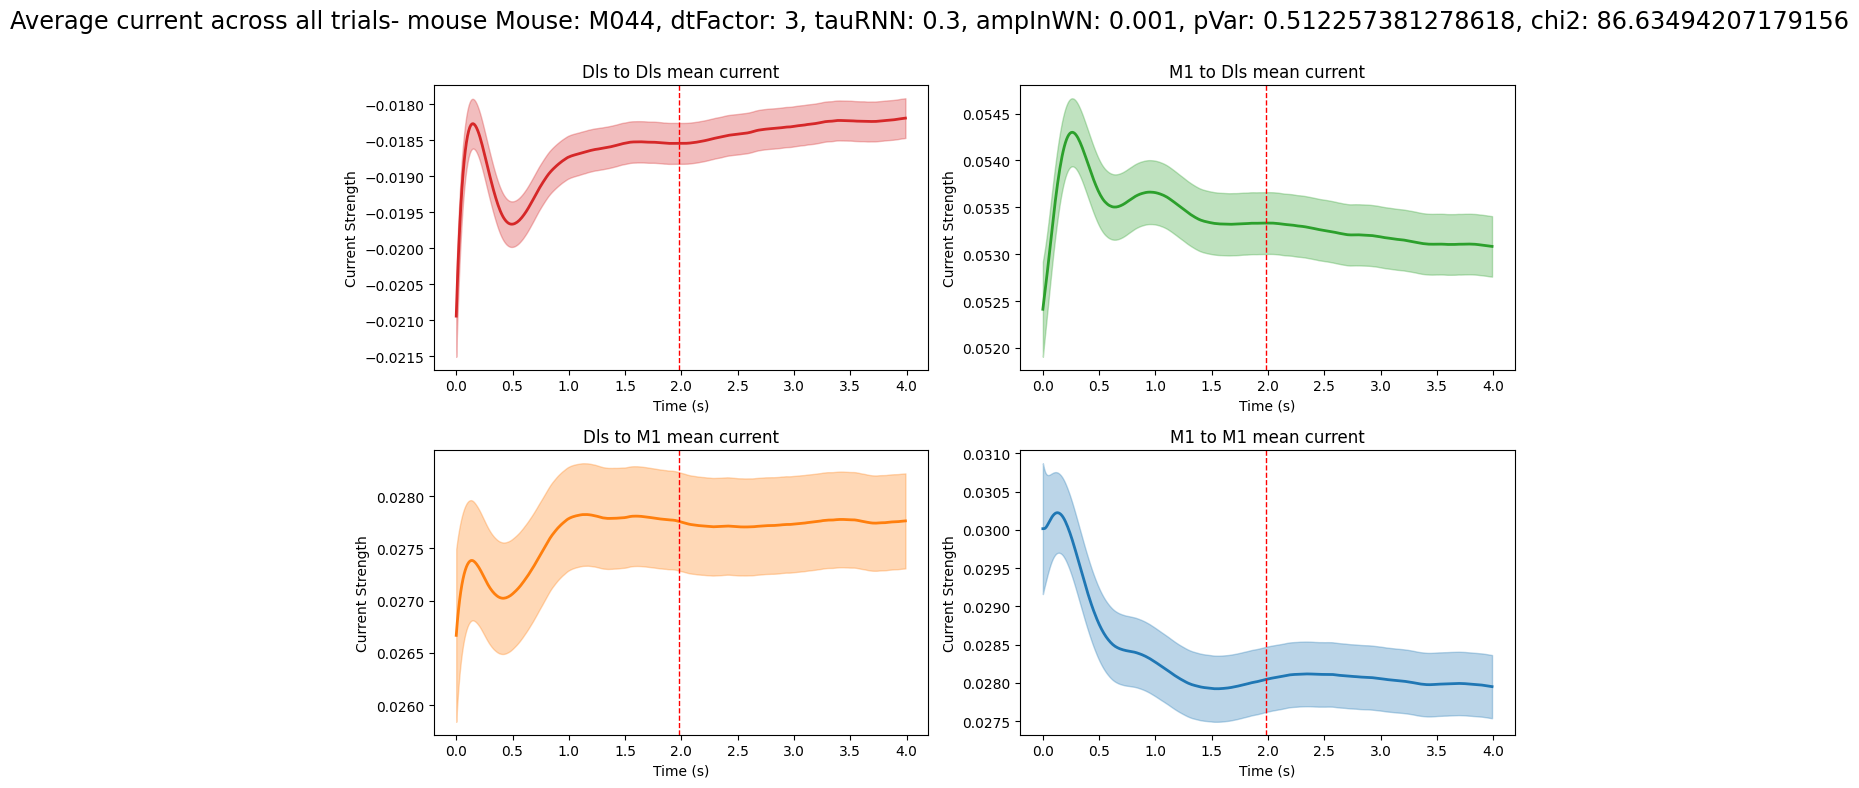

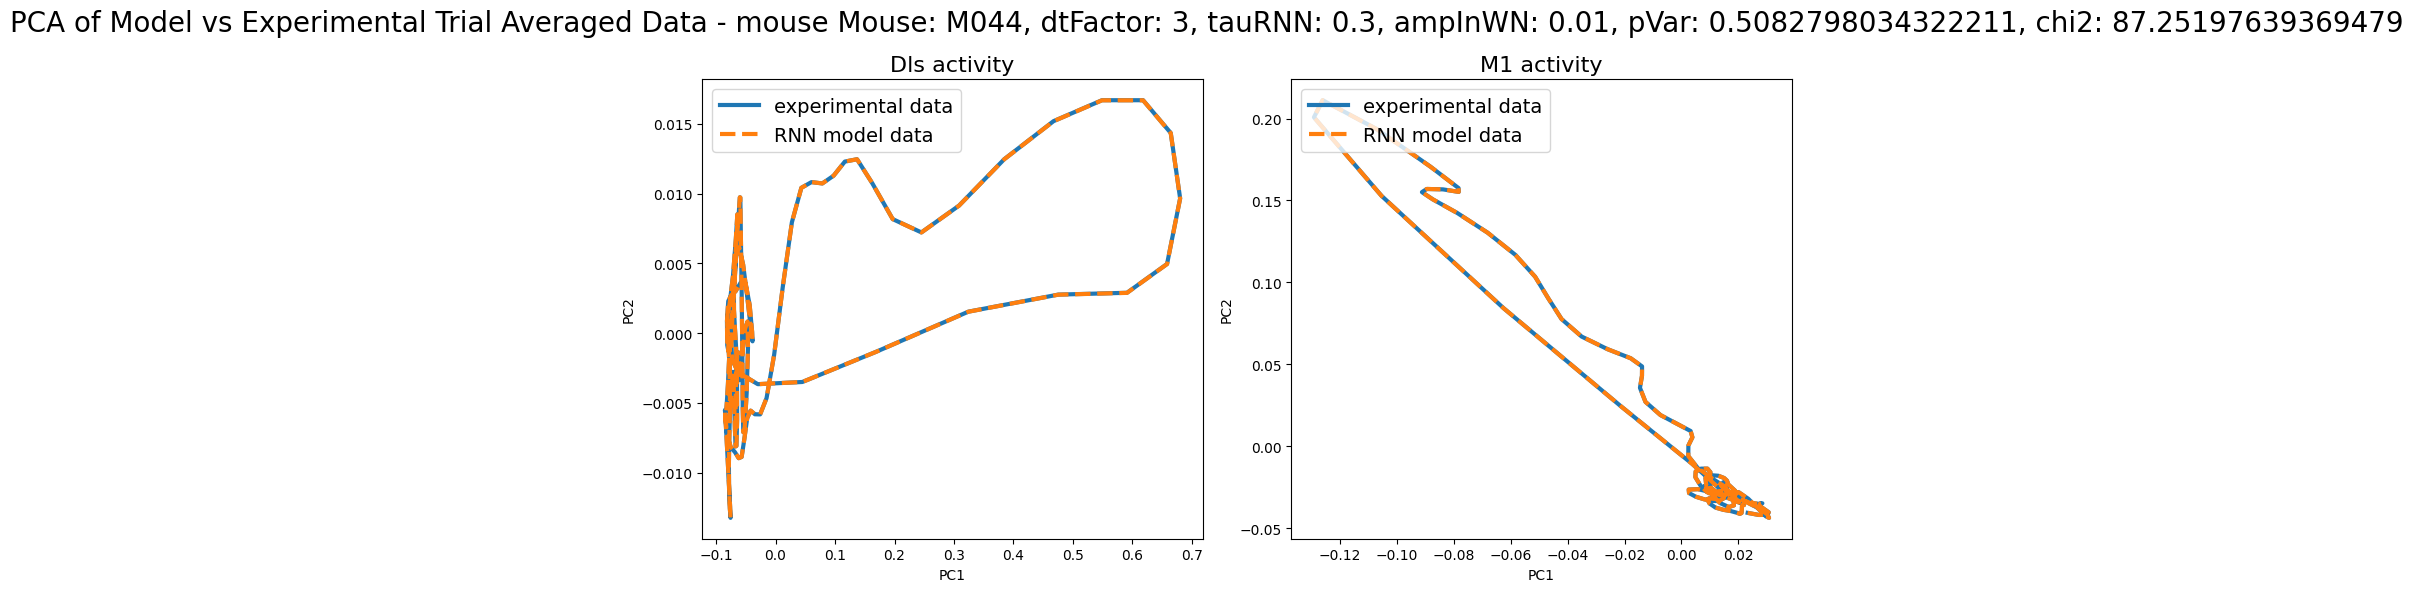

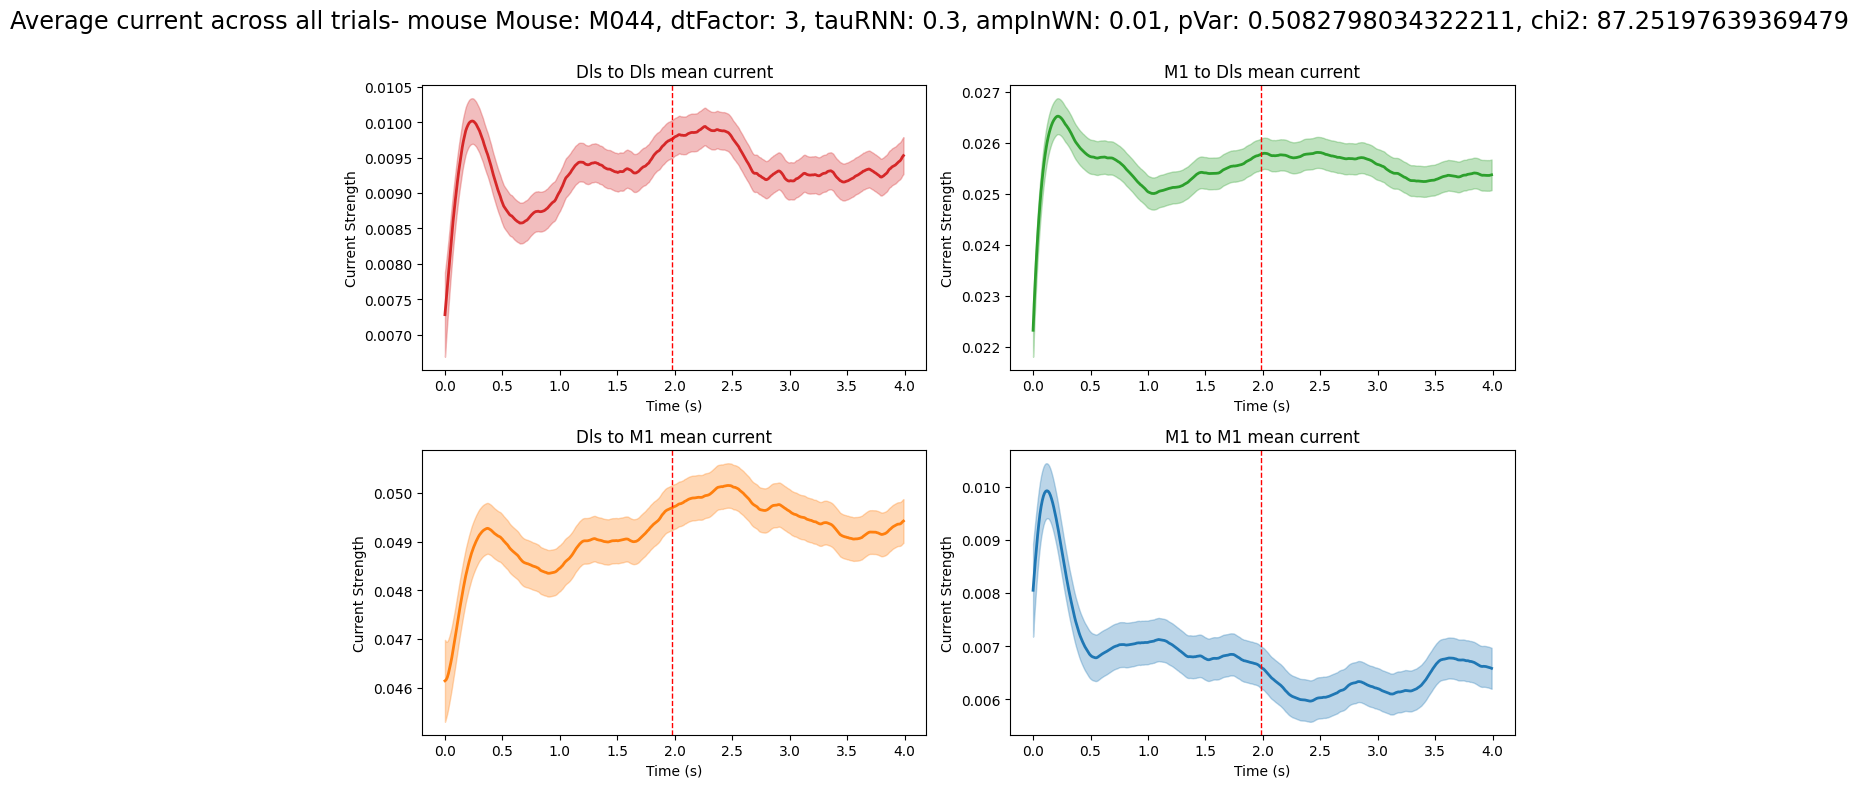

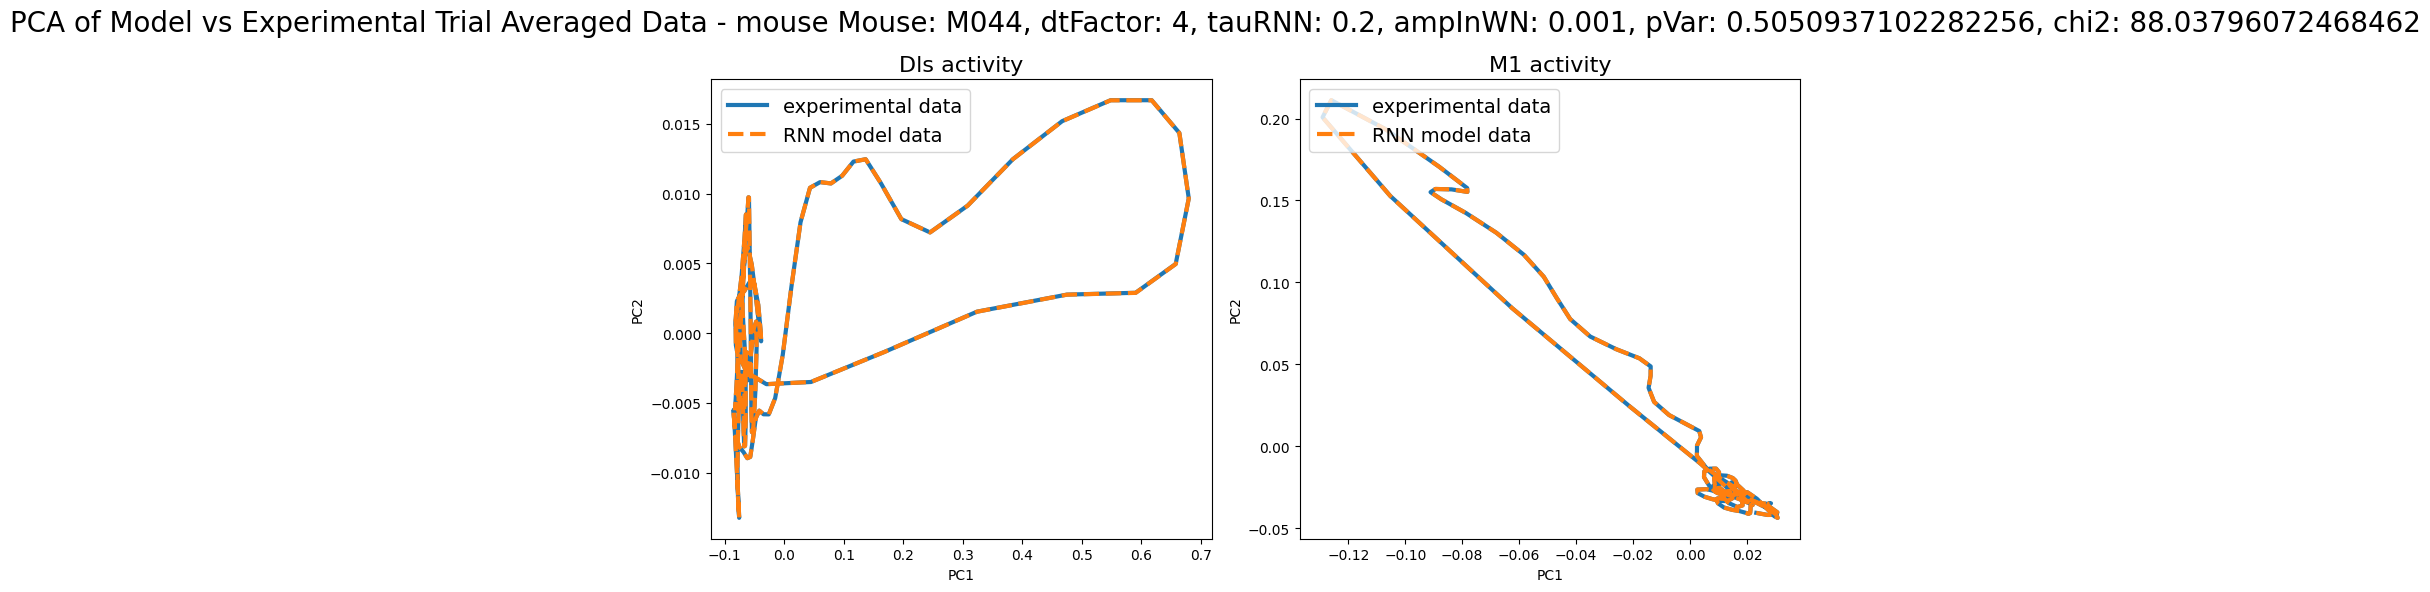

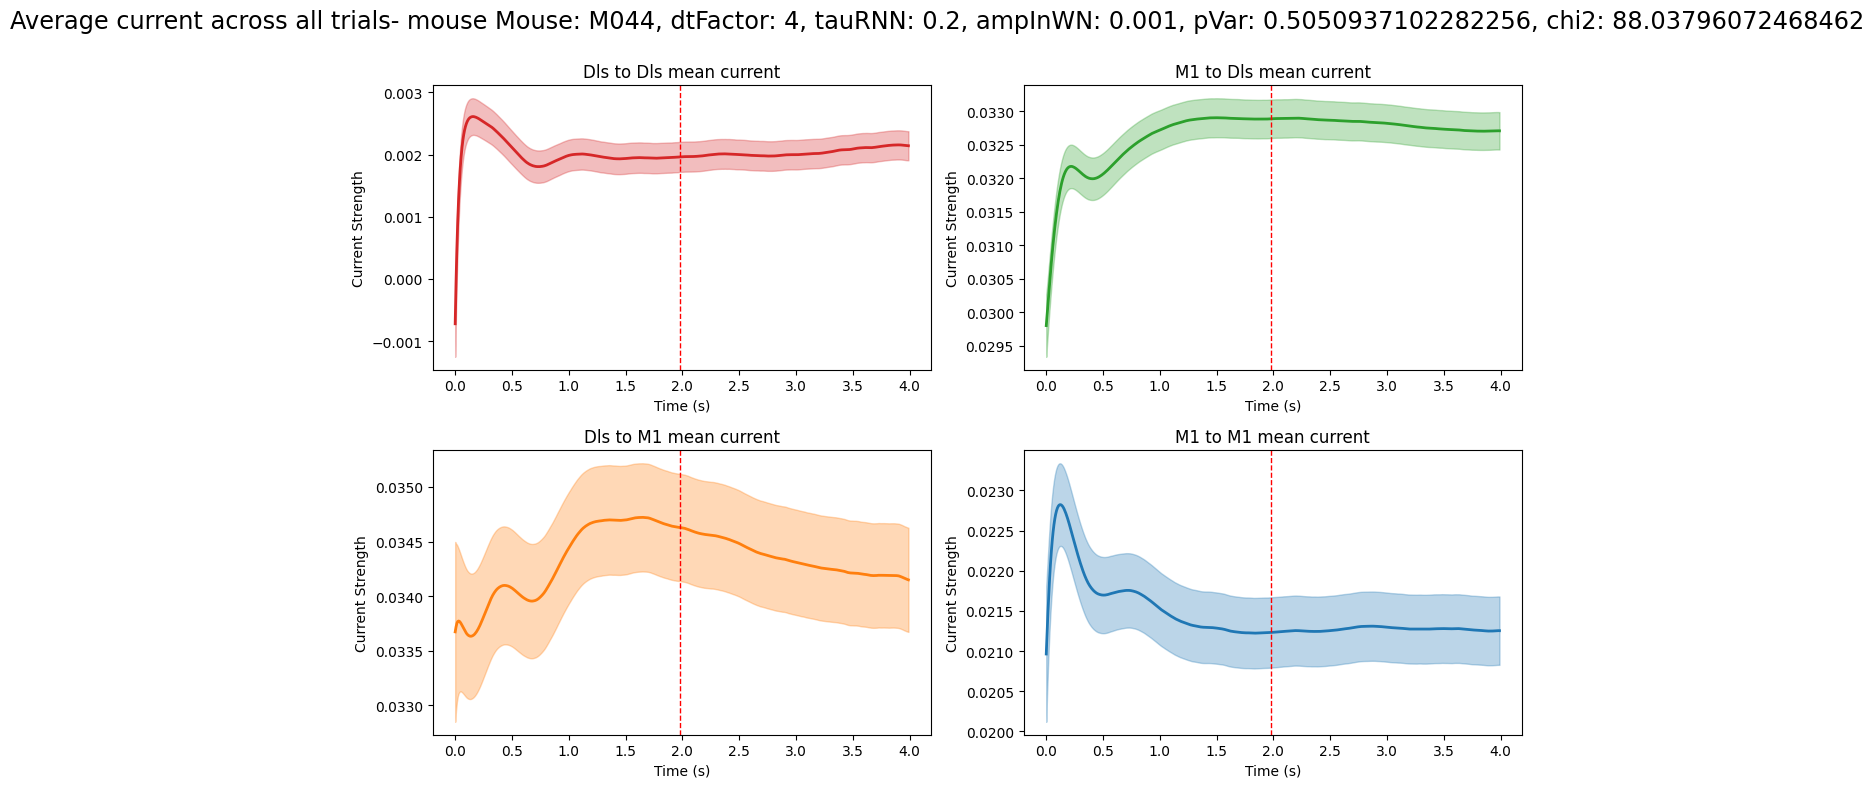

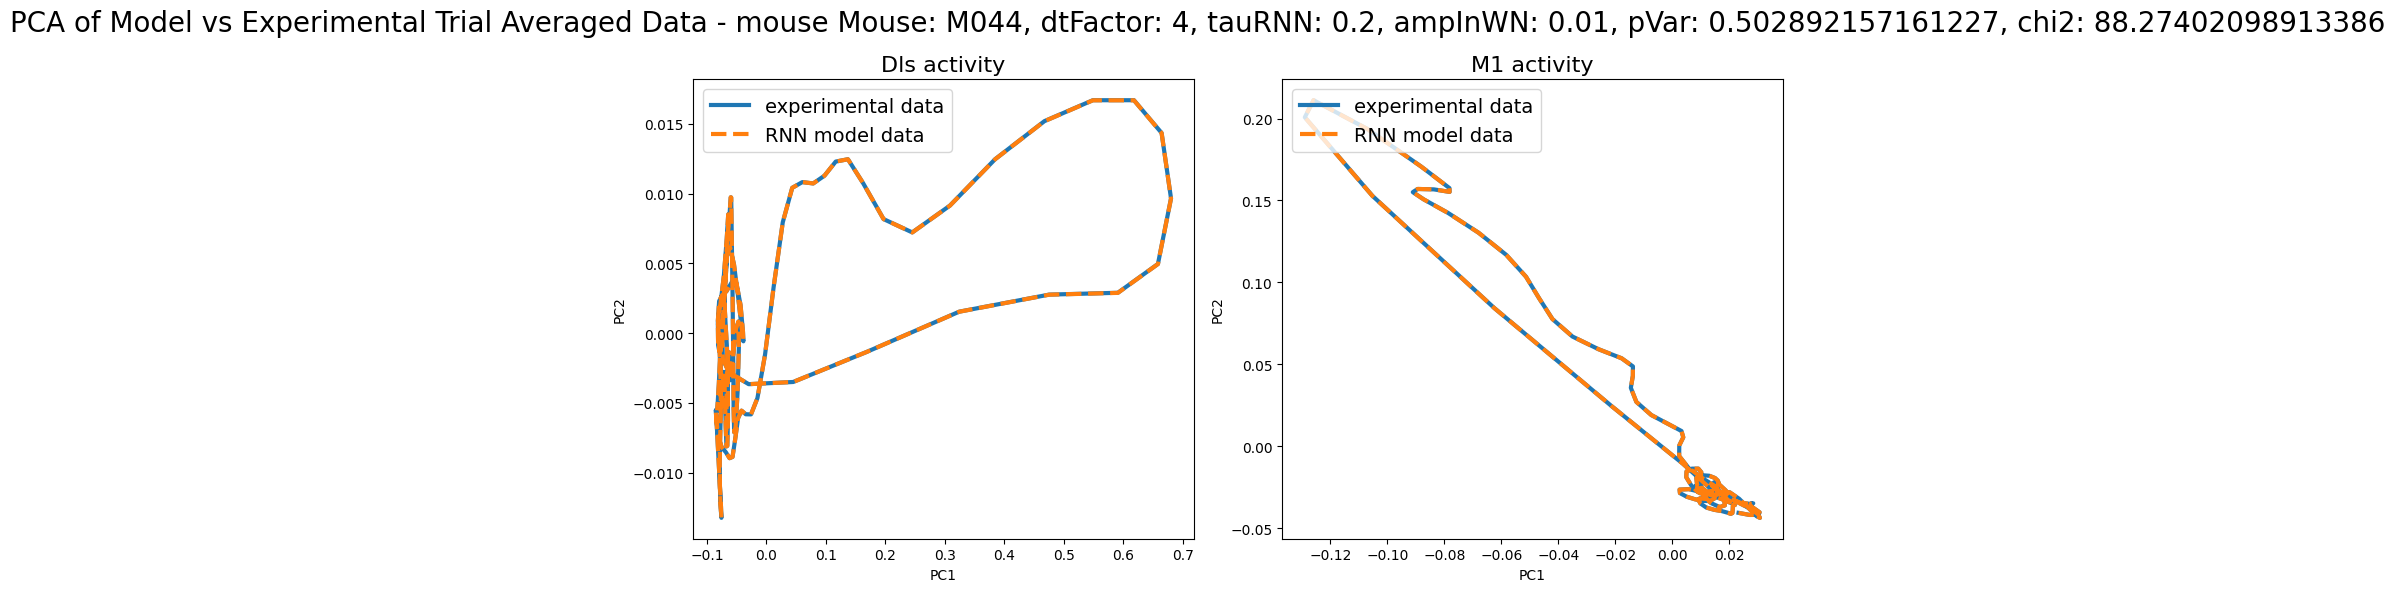

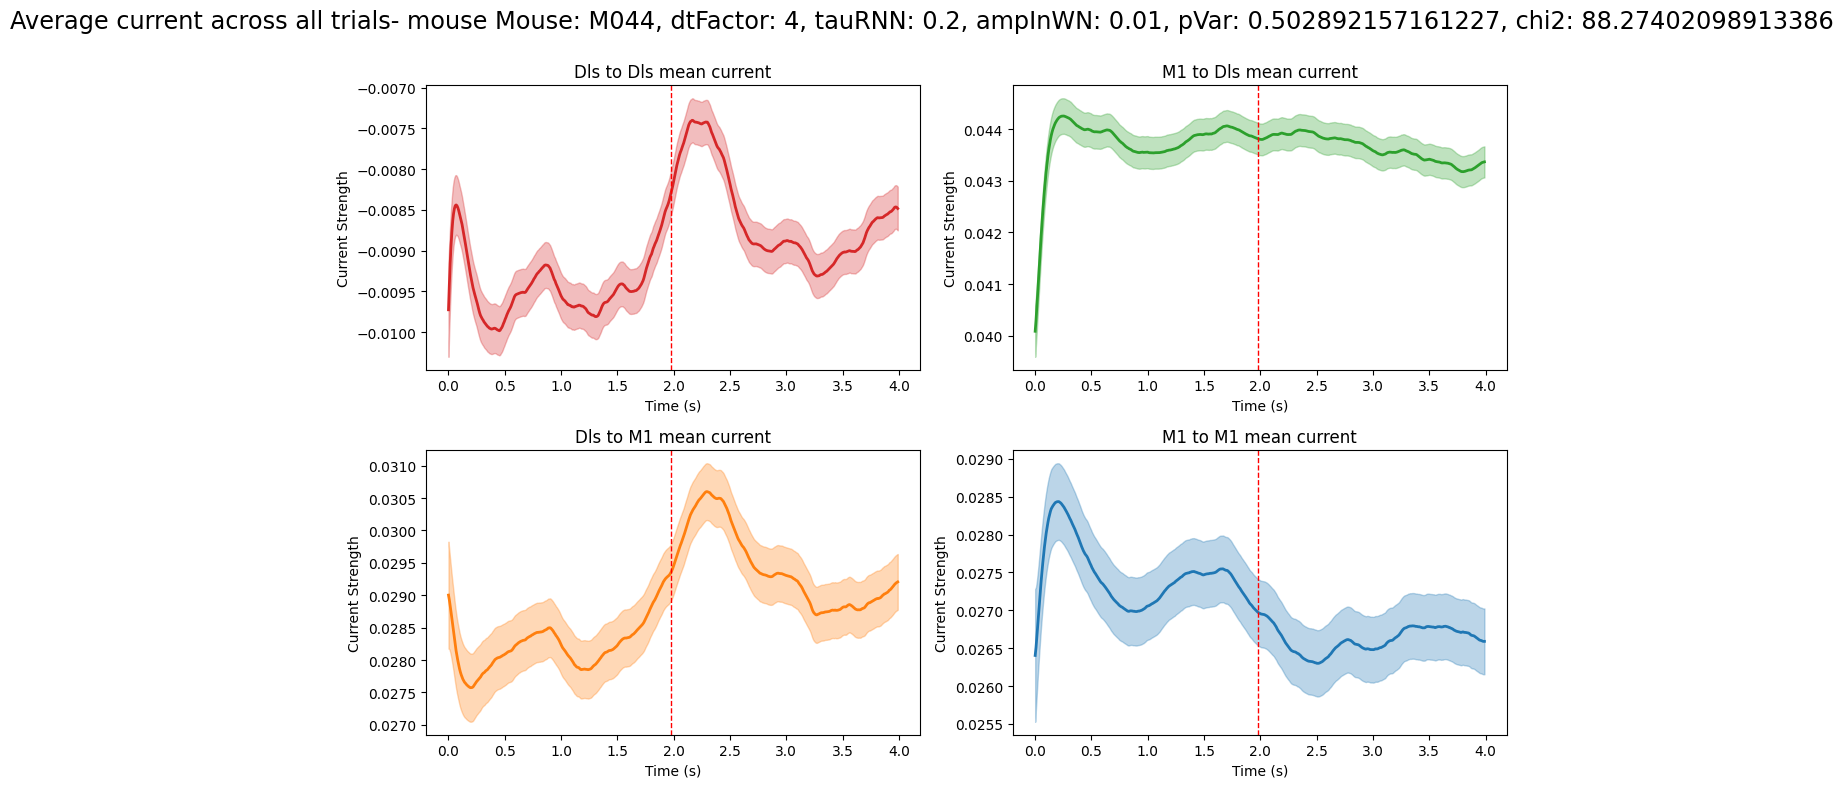

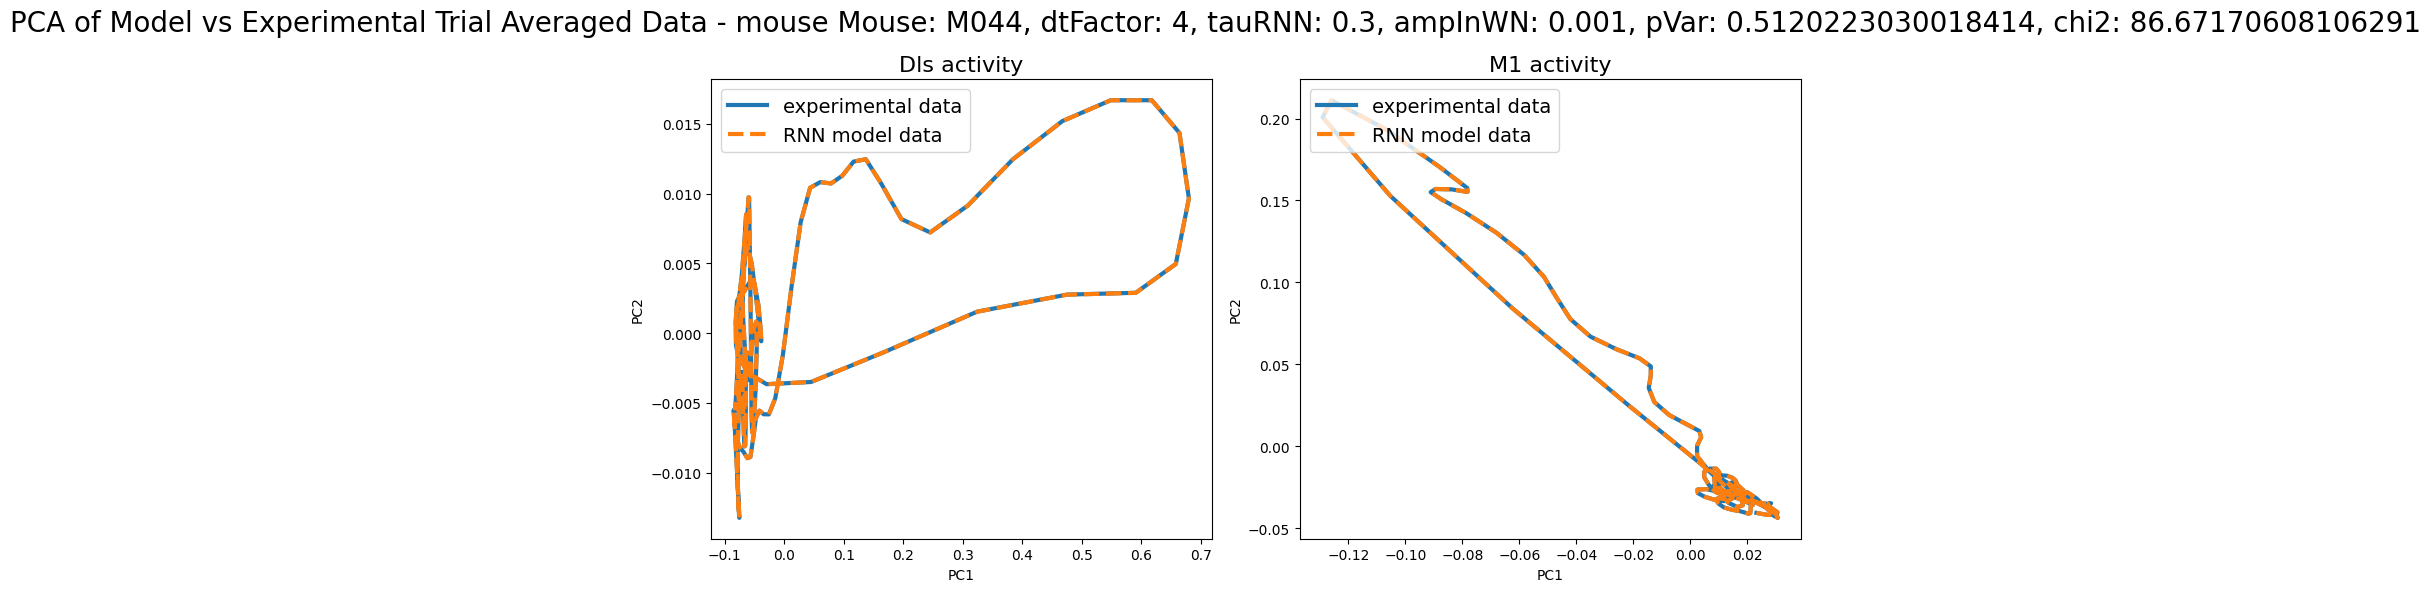

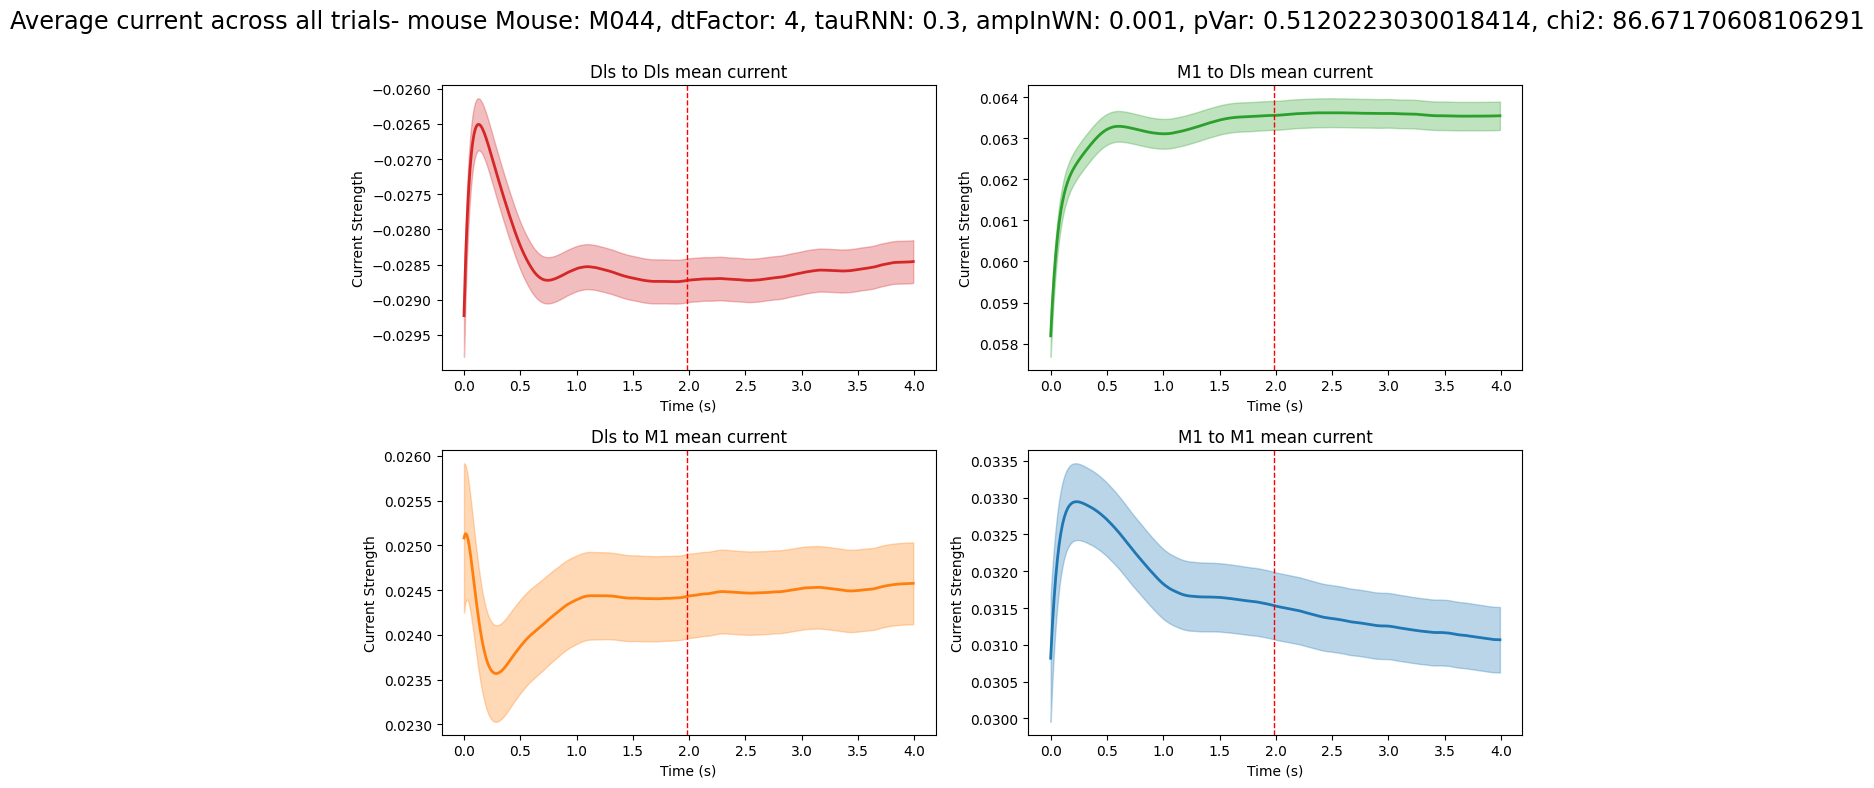

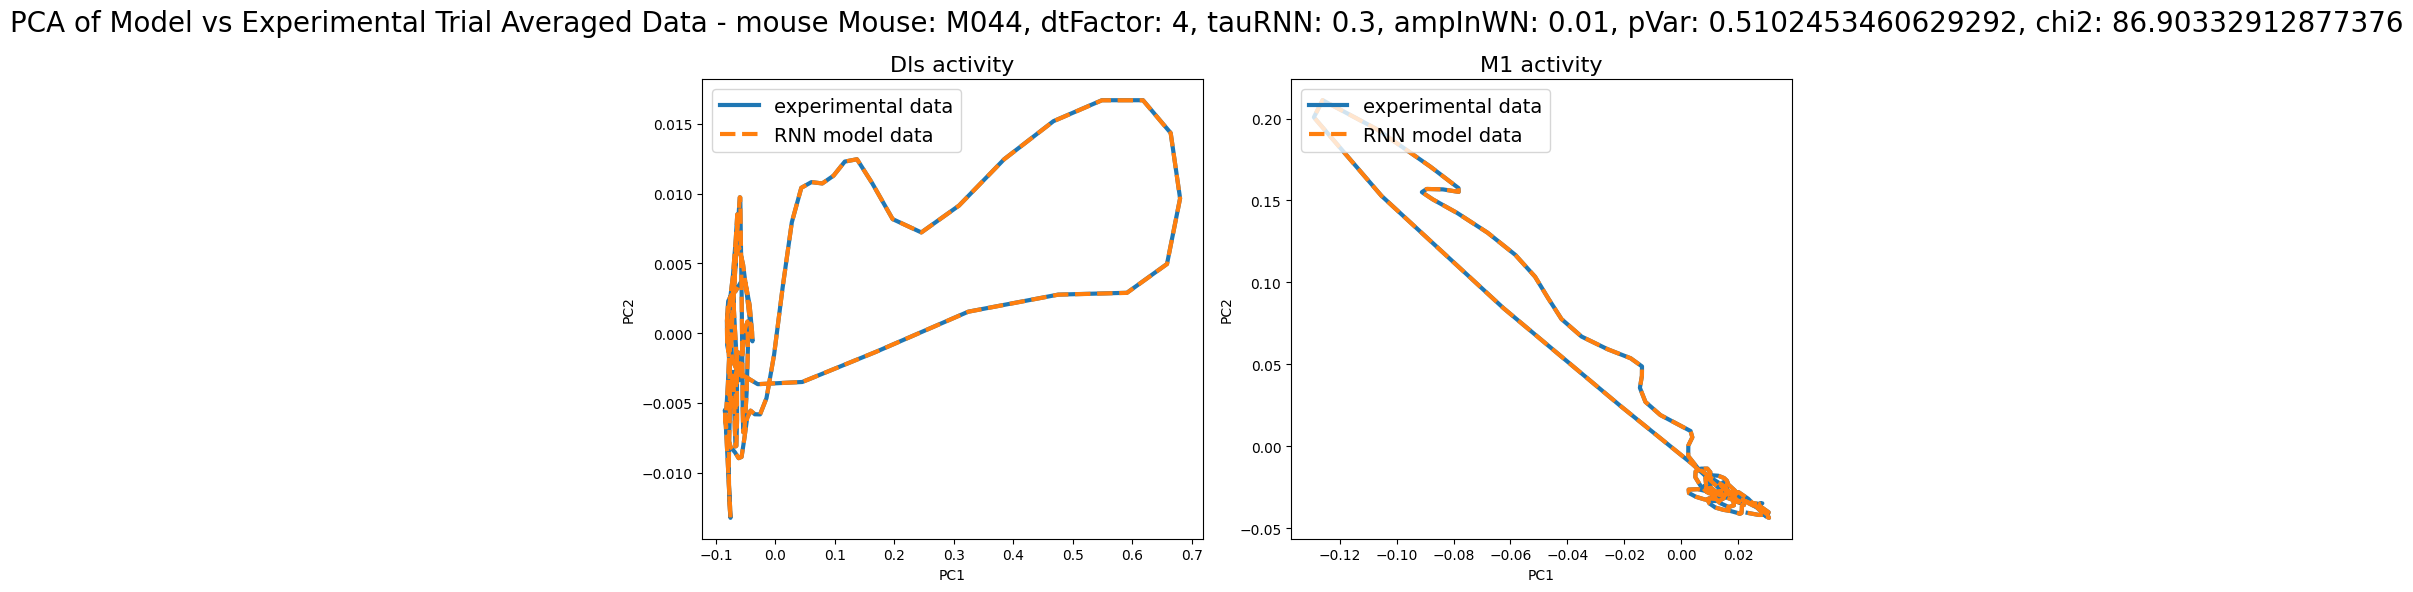

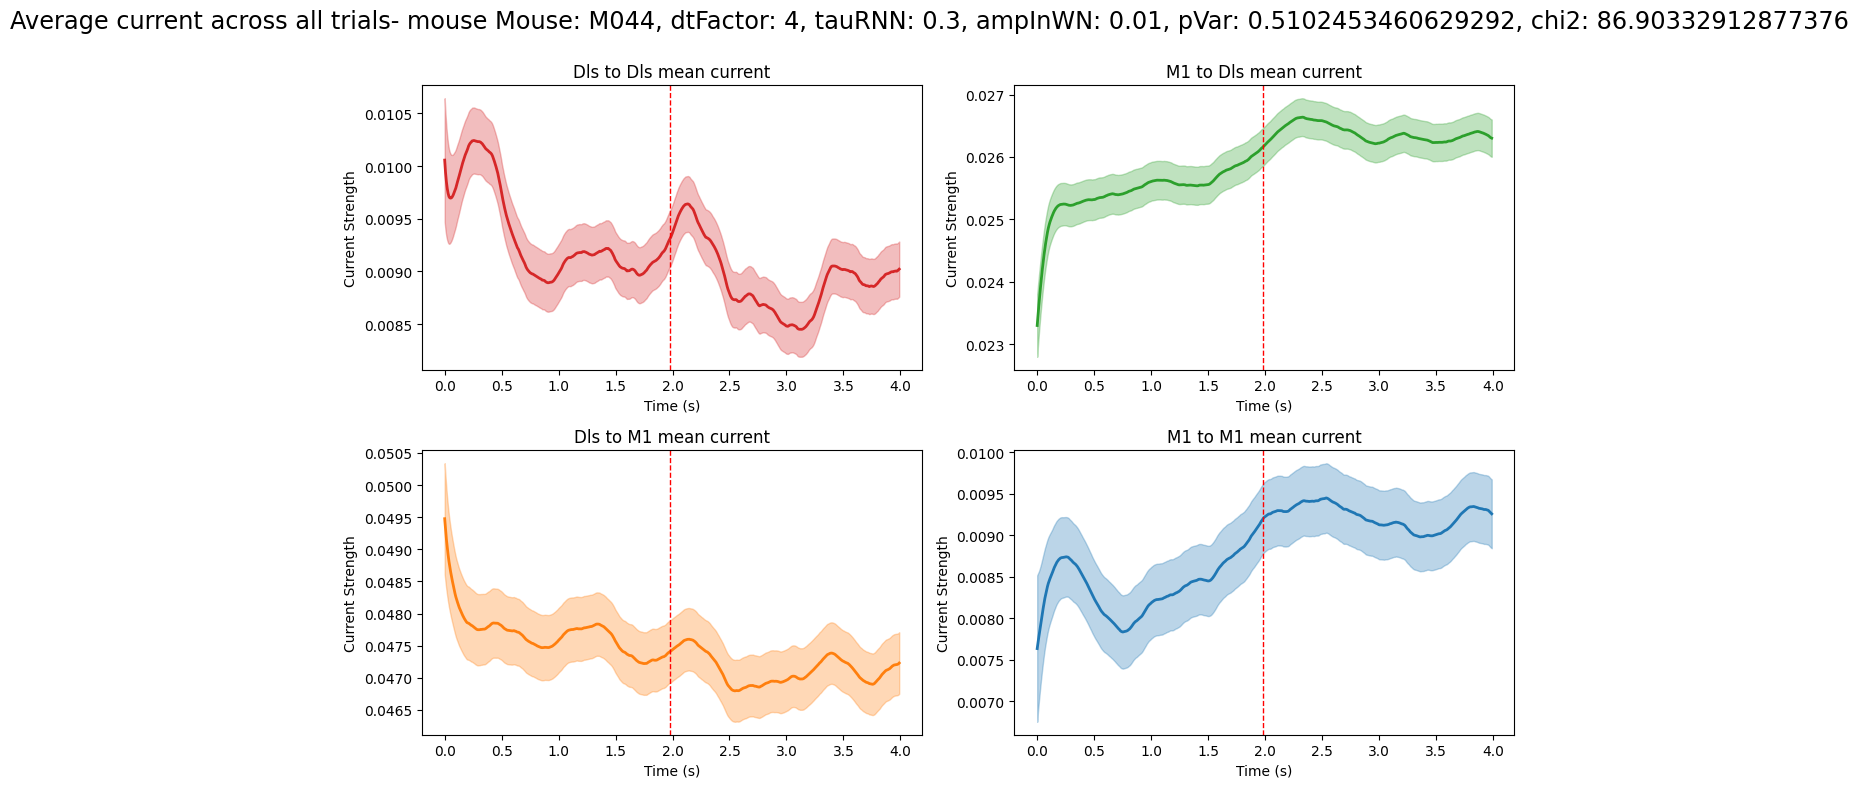

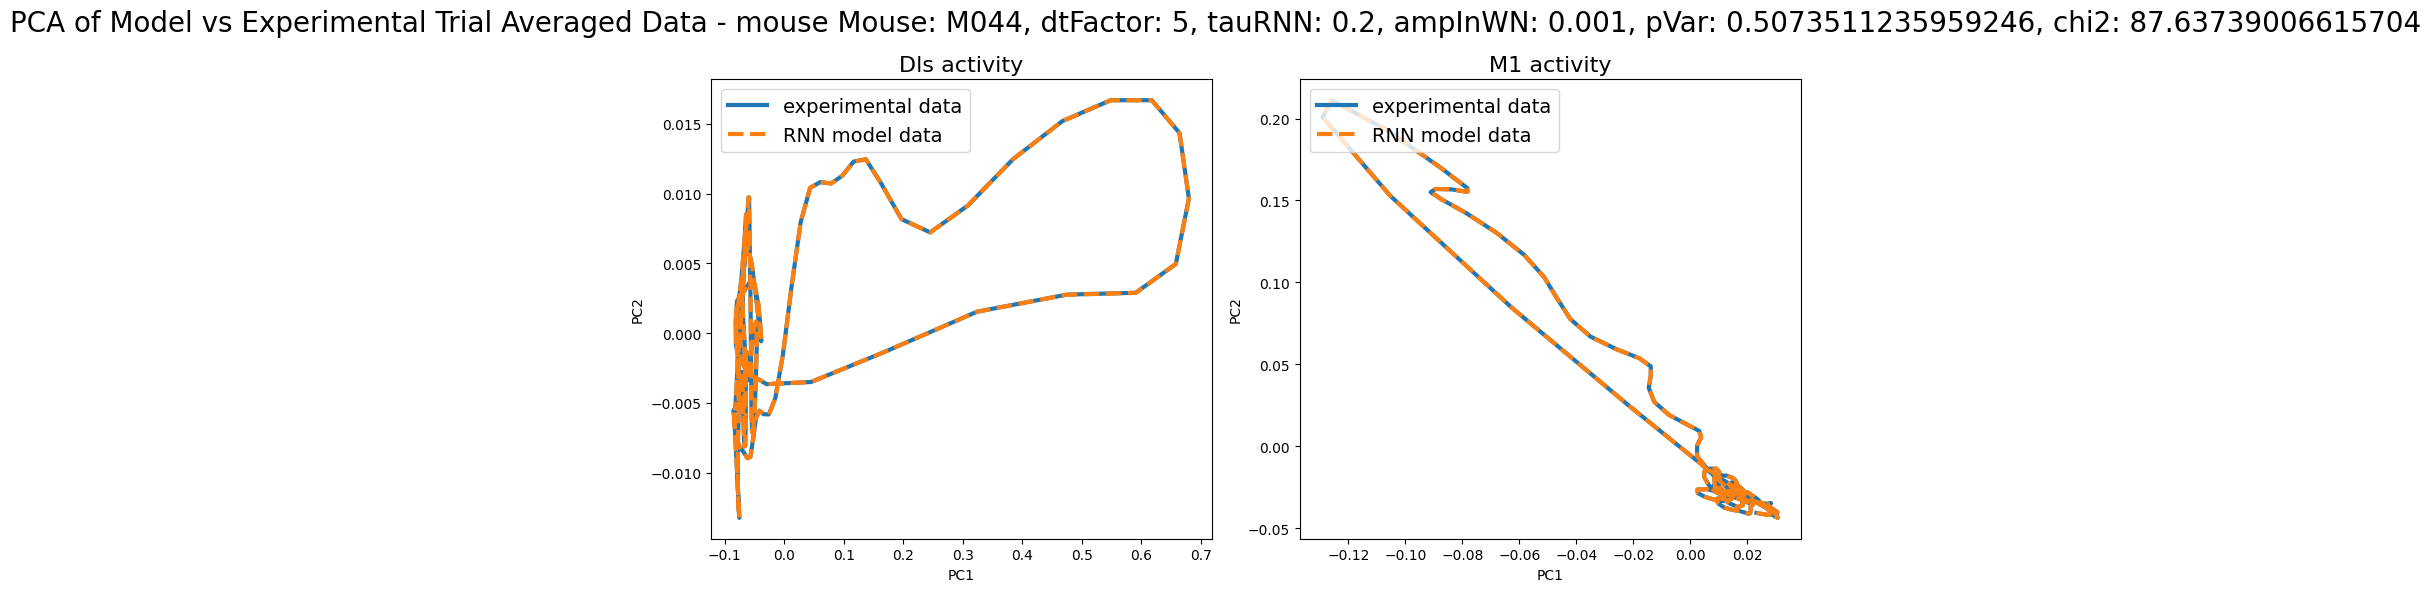

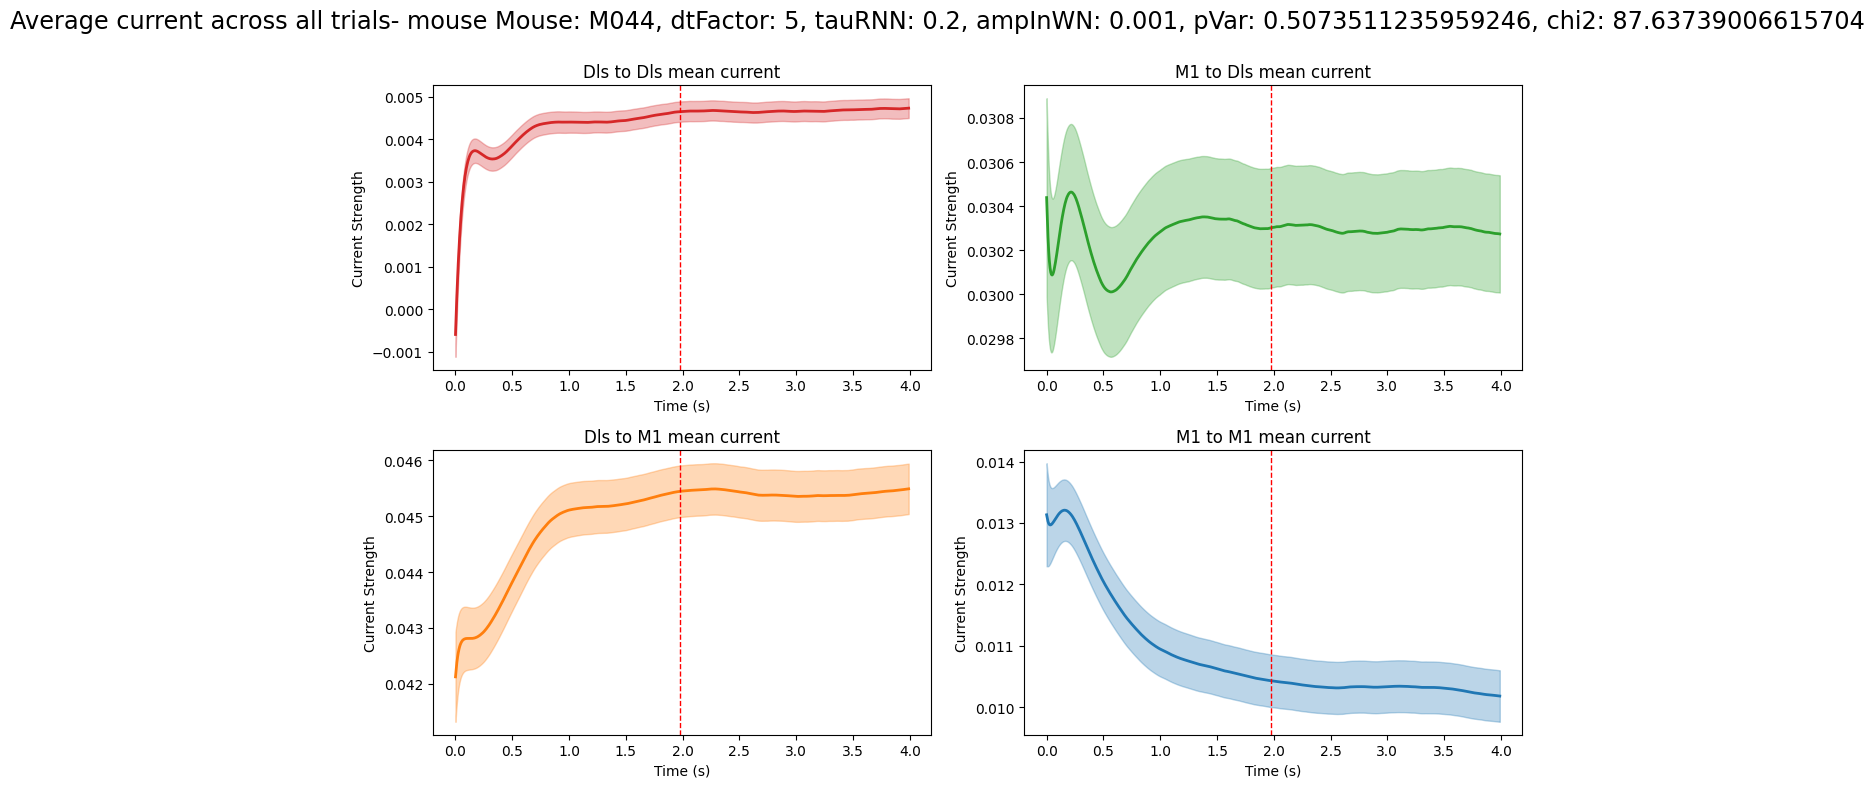

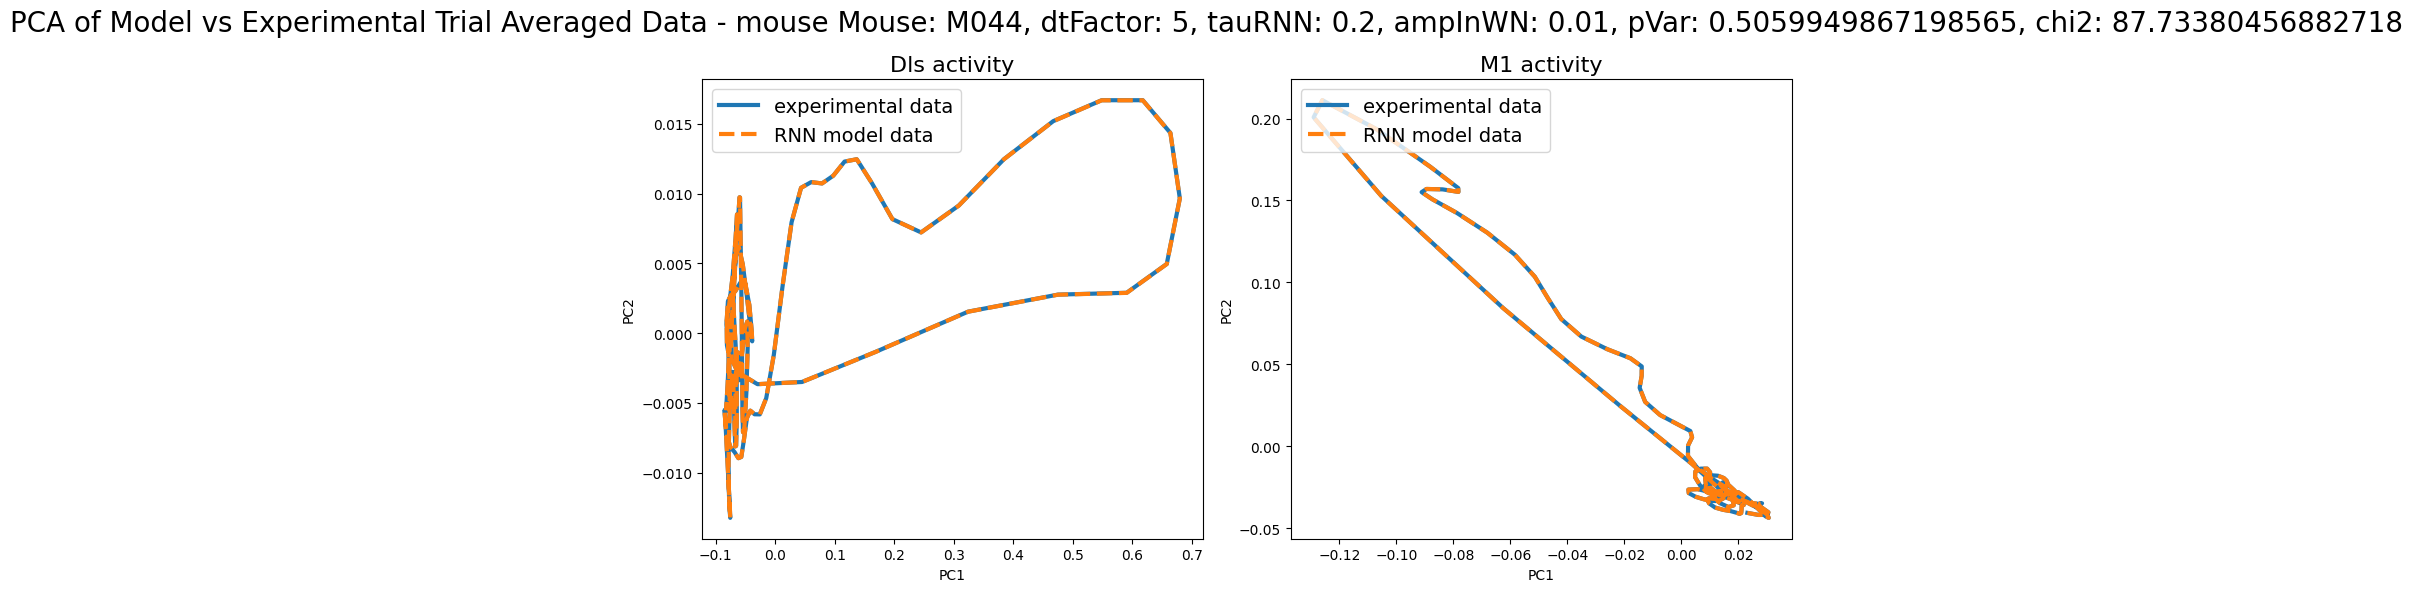

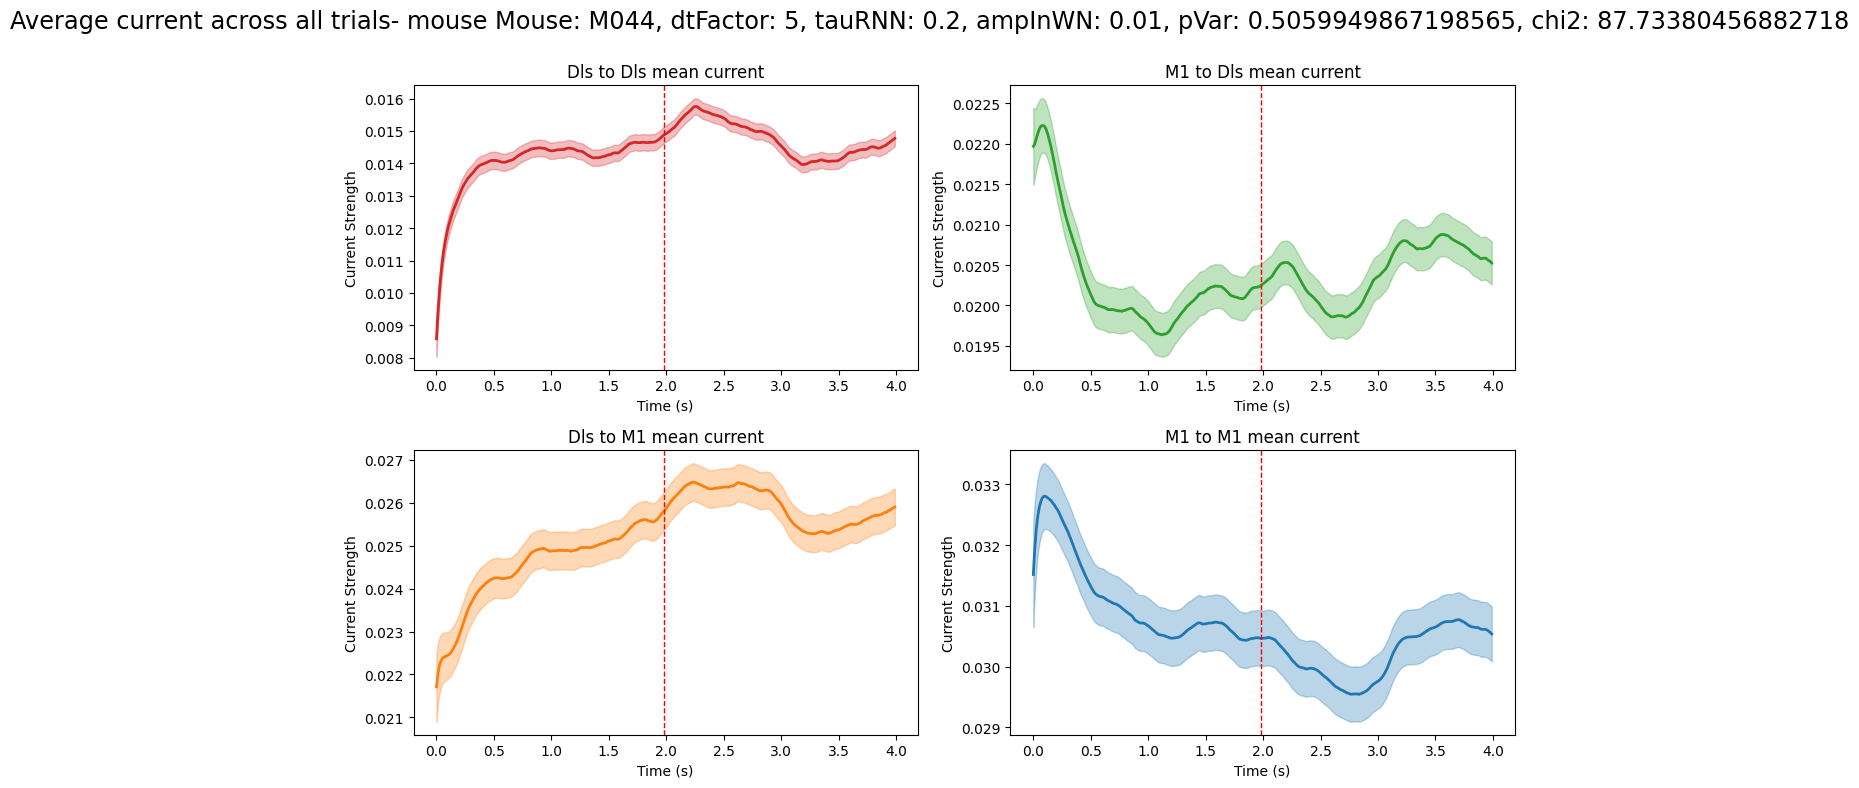

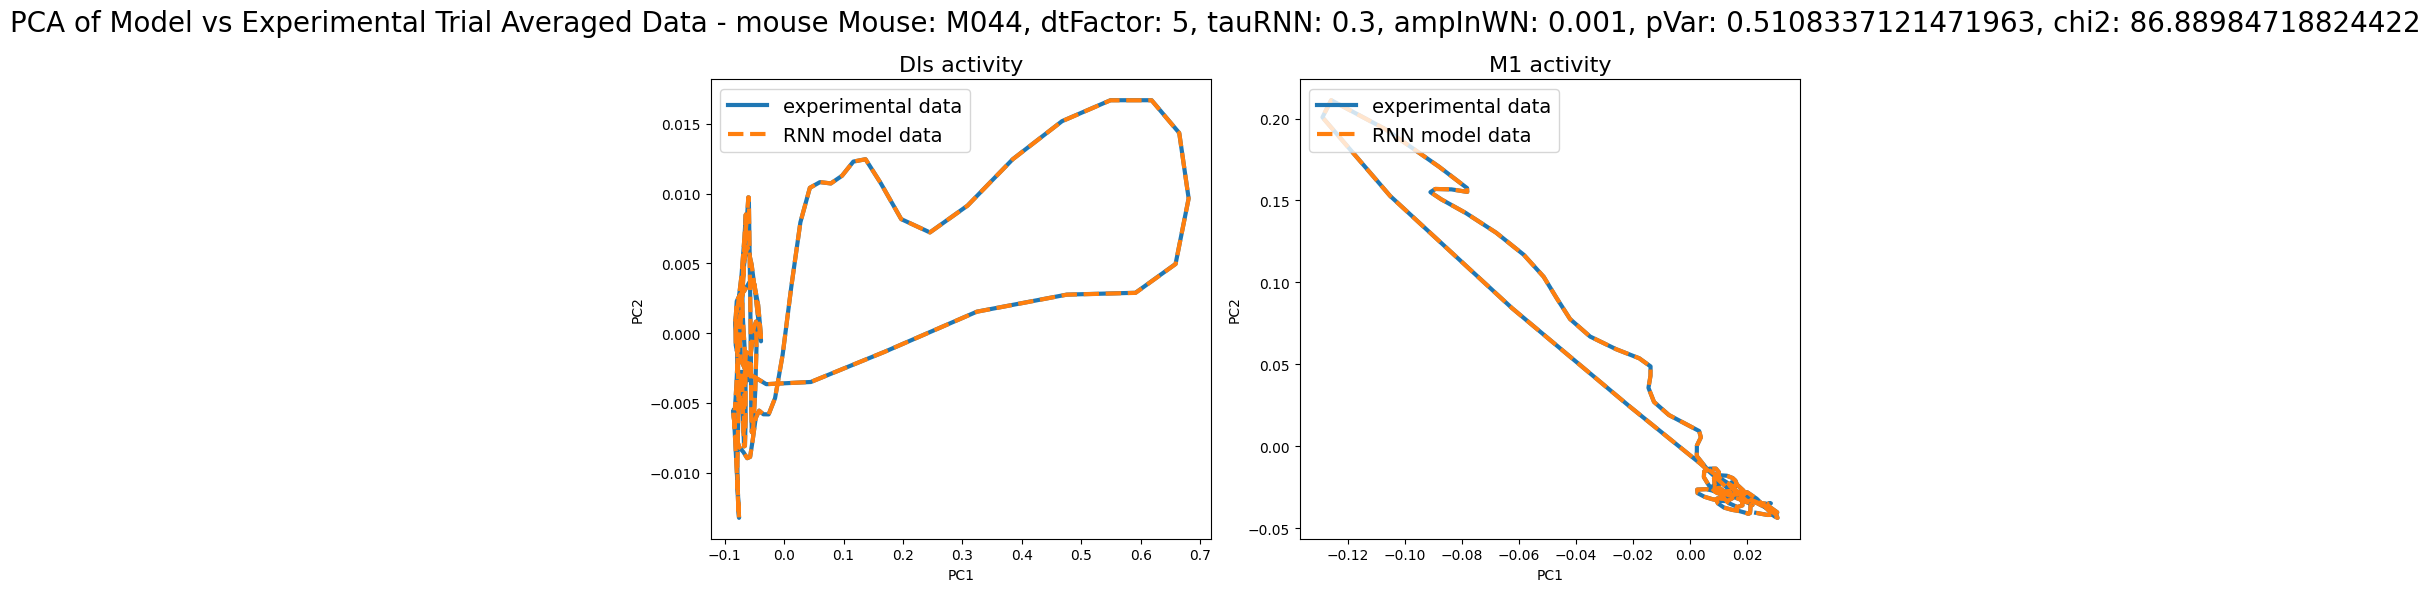

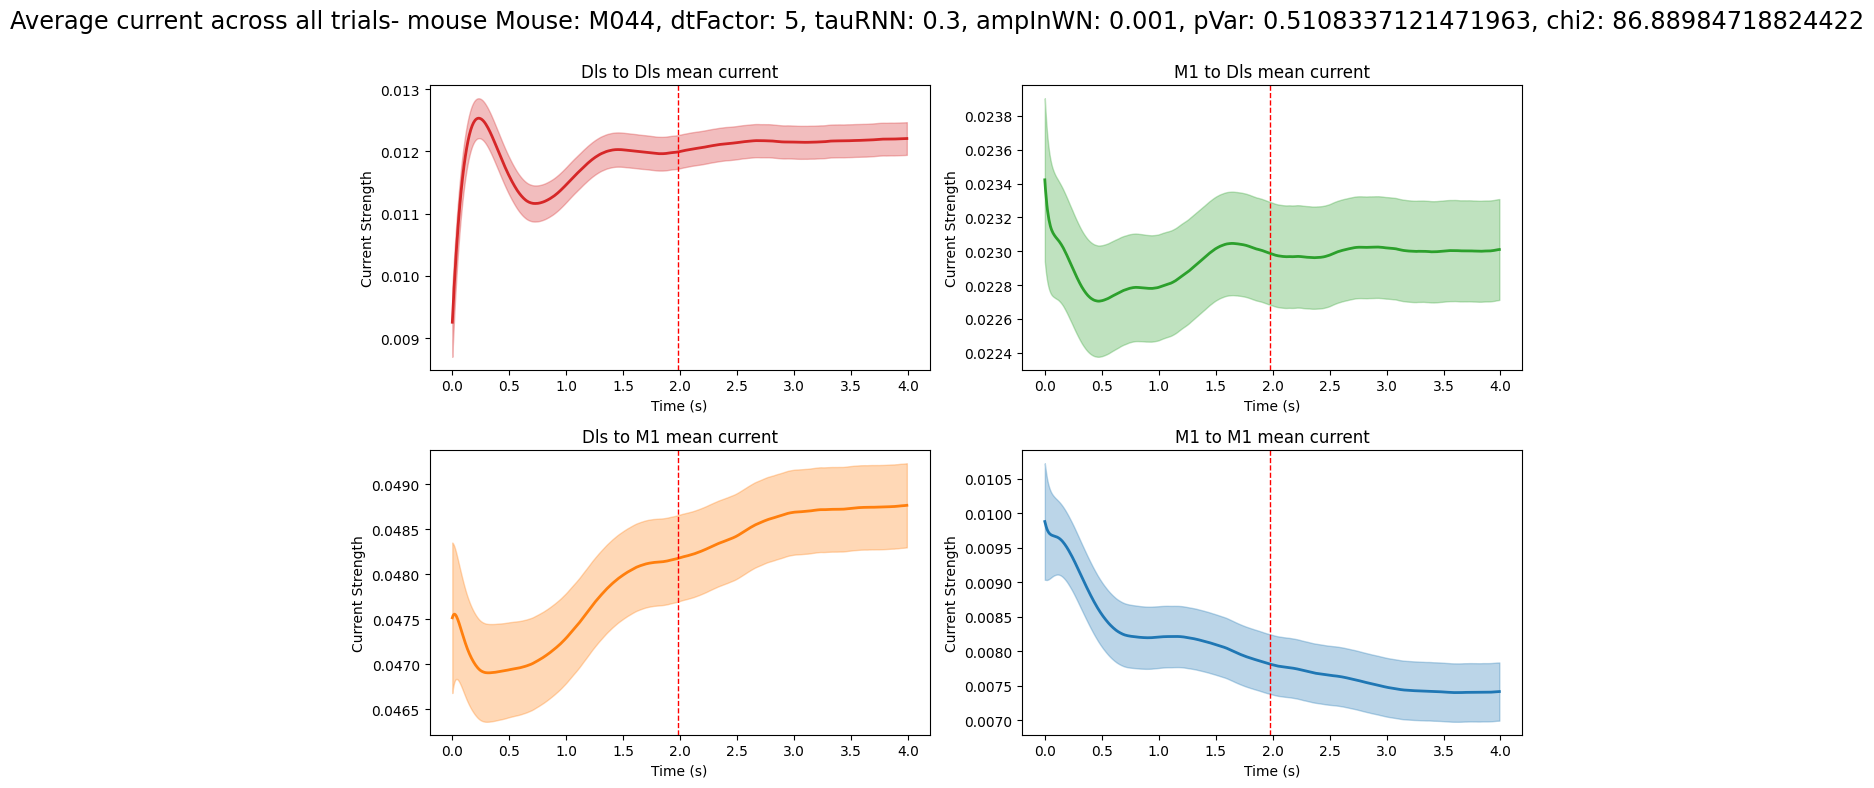

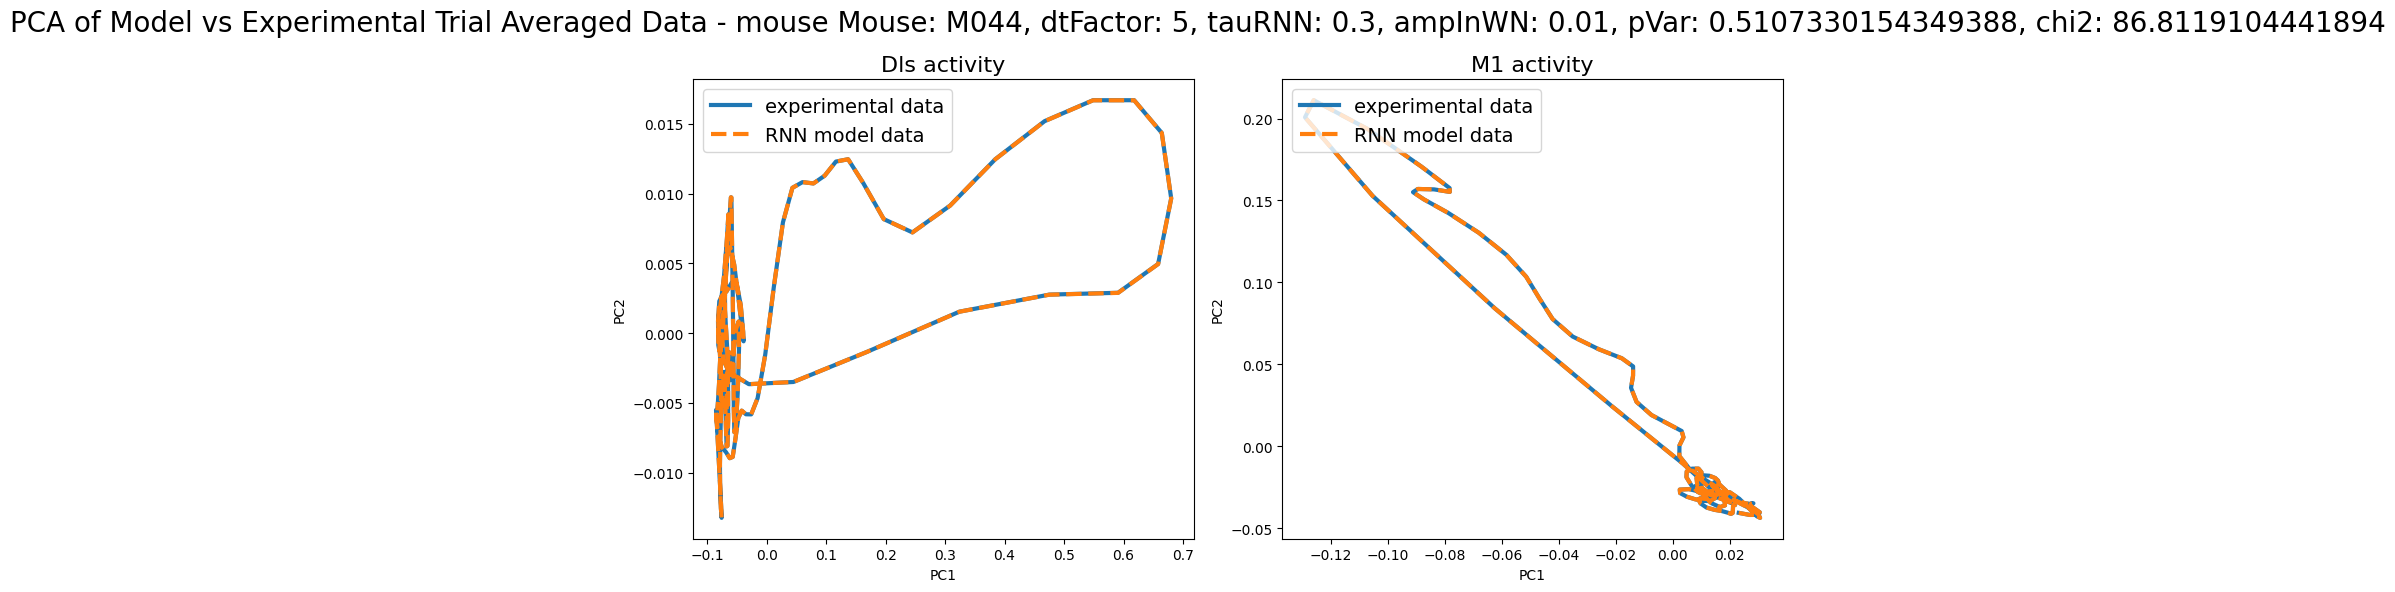

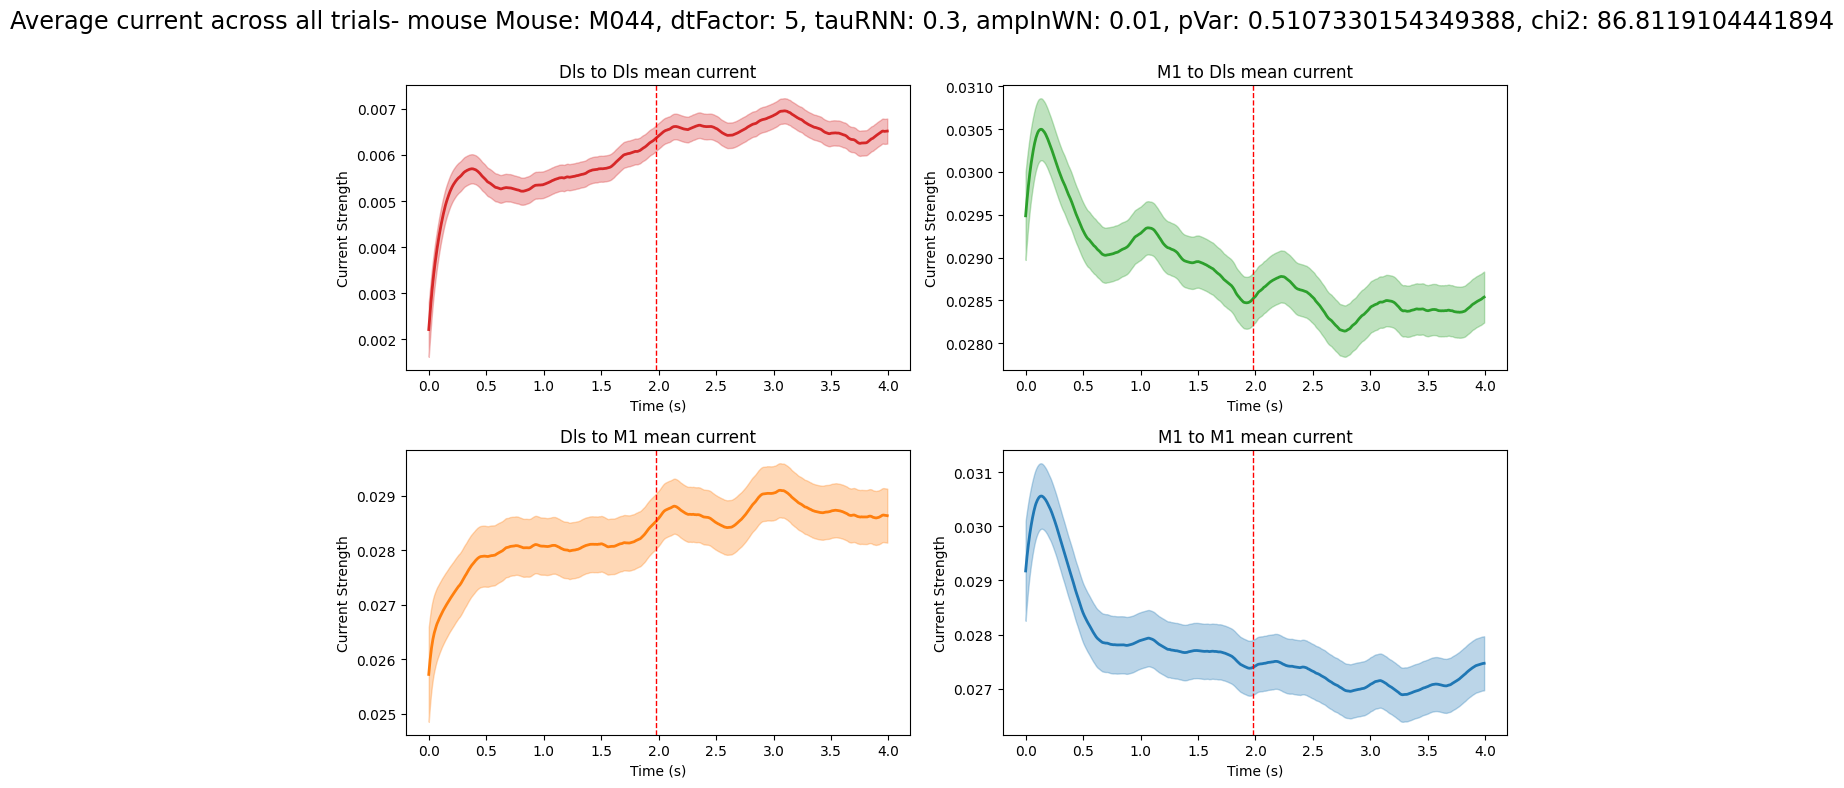

In [14]:
for model in rnn_models:
    params, rnn_model = model
    dtFactor, tauRNN, ampInWN, trial_len, reset_points = params
    # print(f"Model with parameters:")
    # print(f"dtFactor: {dtFactor}, tauRNN: {tauRNN}, ampInWN: {ampInWN}")
    # print(f"Model final accuracy: pVar={rnn_model['pVars'][-1]}, chi2={rnn_model['chi2s'][-1]}\n")
    model_description = f"Mouse: {mouse}, dtFactor: {dtFactor}, tauRNN: {tauRNN}, ampInWN: {ampInWN}, pVar: {rnn_model['pVars'][-1]}, chi2: {rnn_model['chi2s'][-1]}"
    PCA_fig = PCA_by_region(concat_trials, rnn_model, regions, num_trials, model_description)

    curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
    n_regions = curbd_arr.shape[0]  

    all_currents, all_currents_labels = format_for_plotting(curbd_arr, curbd_labels, n_regions, reset_points)

    avg_currents_fig = plot_all_currents_seperate(all_currents, all_currents_labels, perturbation_time_seconds, df_.bin_size[0], dtFactor, model_description, plot_single = False)

In [15]:
column_names = ["model_idx", "binSize", "dtFactor", "tauRNN", "ampInWN", "pVar", "chi2"]
model_df = pd.DataFrame(columns=column_names)

for i, model in enumerate(rnn_models):
    params, rnn_model = model
    dtFactor, tauRNN, ampInWN, trial_len, reset_points = params
    pVar = rnn_model['pVars'][-1]
    chi2 = rnn_model['chi2s'][-1]

    model_df.loc[i] = [i, df_.bin_size[0], dtFactor, tauRNN, ampInWN, pVar, chi2]

In [16]:
model_df.head()

model_idx  binSize  dtFactor  tauRNN  ampInWN      pVar       chi2
0        0.0     0.03       1.0     0.2    0.001  0.499113  89.227929
1        1.0     0.03       1.0     0.2    0.010  0.495637  89.683137
2        2.0     0.03       1.0     0.3    0.001  0.506415  87.762568
3        3.0     0.03       1.0     0.3    0.010  0.504062  88.061292
4        4.0     0.03       2.0     0.2    0.001  0.504828  88.118984

In [32]:
model_df.to_csv('rnn_and_curbd_single_trial_param_sweep.csv', index=False)

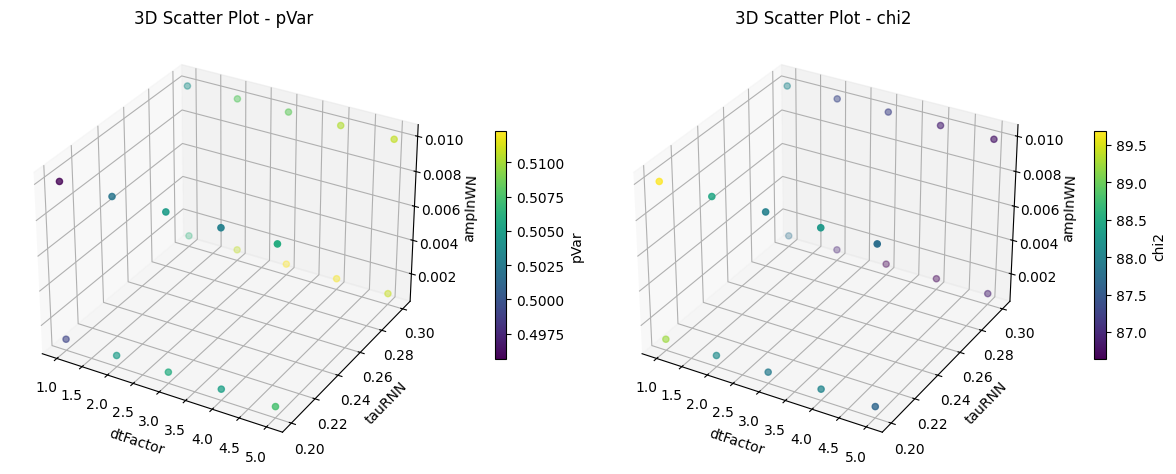

In [31]:
fig = plt.figure(figsize=(12, 6))

for i, metric in enumerate(['pVar', 'chi2']):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    ax.scatter(model_df['dtFactor'], model_df['tauRNN'], model_df["ampInWN"], c=model_df[metric], cmap='viridis')

    ax.set_xlabel("dtFactor")
    ax.set_ylabel("tauRNN")
    ax.set_zlabel("ampInWN")
    fig.colorbar(ax.collections[0], label=metric, shrink=0.4,  pad=0.1)
    ax.set_title(f"3D Scatter Plot - {metric}")
plt.tight_layout()